### Imports & Configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set_palette("colorblind")

# Data Analysis

### Tables


In [2]:
### 1. Load Data
column_names = [
    "reference", "location", "price", "title", "bedrooms", 
    "bathrooms", "indoor_surface", "outdoor_surface", "features"
]

# Load data with flexible NA handling
df = pd.read_csv("../data/properties.csv", header=None, names=column_names, na_values=["NA", "nan", ""])

In [3]:
print("--- Starting Data Cleaning & Consistency Check ---")

# --- A. Numeric Cleaning ---
# Price: Remove symbols, handle comma decimals if necessary, convert to float
df['price'] = df['price'].astype(str).str.replace('€', '').str.replace(',', '').str.strip()
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Surface Areas: Remove 'm2', 'sqm', 'sqft' units before converting
# We define a helper to clean and convert to numeric to avoid repetition
def clean_to_numeric(series, remove_chars):
    clean_series = series.astype(str).str.lower()
    for char in remove_chars:
        clean_series = clean_series.str.replace(char, '')
    return pd.to_numeric(clean_series.str.strip(), errors='coerce')

df['indoor_surface'] = clean_to_numeric(df['indoor_surface'], ['m2', 'sqm', 'sq m', 'm²', ','])
df['outdoor_surface'] = clean_to_numeric(df['outdoor_surface'], ['m2', 'sqm', 'sq m', 'm²', ','])

# Bedrooms/Bathrooms: Remove words like 'beds', 'baths'
df['bedrooms'] = clean_to_numeric(df['bedrooms'], ['bedrooms', 'bedroom', 'beds', 'bed'])
df['bathrooms'] = clean_to_numeric(df['bathrooms'], ['bathrooms', 'bathroom', 'baths', 'bath'])

# [NEW] Fill NA for Outdoor Surface
# We assume if outdoor surface is missing, the property likely has no outdoor space (0 sqm).
df['outdoor_surface'] = df['outdoor_surface'].fillna(0)


# Other numeric columns
numeric_cols = ['bedrooms', 'bathrooms', 'indoor_surface', 'outdoor_surface']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# --- B. String Consistency (Categorical) ---
# 1. Split 'location' -> City, Region
location_split = df['location'].str.split(',', n=1, expand=True)

# Clean: Strip whitespace and Title Case for consistency (e.g., " marbella" -> "Marbella")
df['city'] = location_split[0].str.strip().str.title()
df['region'] = location_split[1].str.strip().str.title()

# 2. Split 'title' -> Property Type
# (Optional helper for integrity check)
df['bedrooms_from_title'] = df['title'].astype(str).str.extract(r'^(\d+)\s*Bedroom').astype(float)
df['property_type'] = df['title'].astype(str).str.replace(r'^\d+\s*Bedrooms?\s*', '', regex=True) # Standard clean
df['property_type'] = df['property_type'].str.replace(r'^\d+\s+', '', regex=True) # Catch leftovers like "1 Detached"
df['property_type'] = df['property_type'].str.replace('For Sale', '').str.strip().str.title()


# --- C. Binary Features (True/False) ---
df['features'] = df['features'].fillna('')
# Create dummies
feature_dummies = df['features'].str.get_dummies(sep='|')

# Clean Column Names: snake_case (lowercase, underscores)
feature_dummies.columns = feature_dummies.columns.str.strip().str.lower().str.replace(' ', '_')

# Convert 0/1 to Boolean (True/False)
feature_dummies = feature_dummies.astype(bool)

# Concatenate back
df = pd.concat([df, feature_dummies], axis=1)

# Remove duplicates created during merge
df = df.loc[:, ~df.columns.duplicated()]

--- Starting Data Cleaning & Consistency Check ---


#### Fixing unit confusion

In [4]:
print("\n--- Checking for Unit Confusion (Sq Ft entries) ---")
# Logic: If a house is huge (>500 sqm) AND dirt cheap per sqm (<300€), 
# it's likely square feet, not square meters. (1 Sqm = 10.764 Sq Ft)

# 1. Calculate Price per Sqm temporarily
price_per_sqm = df['price'] / df['indoor_surface']

# 2. Identify the error rows
# Thresholds: Surface > 500 (Big) AND Price/sqm < 300 (Too cheap)
mask_sqft = (df['indoor_surface'] > 500) & (price_per_sqm < 300)

# 3. Apply conversion
if mask_sqft.sum() > 0:
    print(f"[Fixing] Found {mask_sqft.sum()} properties likely in Sq Ft. Converting to Sq Meters...")
    # Show an example before fix
    print(f"Example before: {df.loc[mask_sqft, 'indoor_surface'].iloc[0]} sqm")
    
    # Divide by 10.764
    df.loc[mask_sqft, 'indoor_surface'] = df.loc[mask_sqft, 'indoor_surface'] / 10.764
    
    # Show example after fix
    print(f"Example after:  {df.loc[mask_sqft, 'indoor_surface'].iloc[0]:.2f} sqm")
else:
    print("No obvious Unit Confusion (Sq Ft) detected.")


--- Checking for Unit Confusion (Sq Ft entries) ---
[Fixing] Found 3 properties likely in Sq Ft. Converting to Sq Meters...
Example before: 4050.0 sqm
Example after:  376.25 sqm


### Mask for residential

In [5]:
print("\n--- Applying Residential Filter ---")
initial_count = len(df)

# Expanded list of non-residential keywords
non_residential_keywords = [
    'Plot', 'Land', 'Commercial', 'Office', 'Shop', 'Garage', 'Warehouse', 
    'Restaurant', 'Business', 'Hotel', 'Bar', 'Nightclub', 'Cafe', 
    'Storage', 'Parking', 'Hospitality', 'Equestrian', 'Farm'
]

# Create mask (case insensitive)
mask = df['property_type'].str.contains('|'.join(non_residential_keywords), case=False, na=False)

# 1. Capture what we are about to remove
df_removed = df[mask]
removed_counts = df_removed['property_type'].value_counts()

# 2. Apply the Filter (Keep what is NOT in the mask)
df = df[~mask].copy()

filtered_count = len(df)

# 3. Report Results
print(f"Initial Count: {initial_count}")
print(f"Removed Rows:  {initial_count - filtered_count}")
print(f"Final Count:   {filtered_count}")

print("\n--- Breakdown of Removed Non-Residential Types ---")
if not removed_counts.empty:
    display(removed_counts.to_frame(name='Count'))
else:
    print("No non-residential types found to remove.")

print("\n--- Remaining Residential Property Types ---")
print(df['property_type'].unique())


--- Applying Residential Filter ---
Initial Count: 12086
Removed Rows:  1481
Final Count:   10605

--- Breakdown of Removed Non-Residential Types ---


,Count
property_type,
Plot,629
Land,248
Commercial Development,112
Restaurant,112
Commercial Property,82
Office,72
Bar / Nightclub,39
Hospitality,39
Garage,34



--- Remaining Residential Property Types ---
['Apartment' 'Other' 'Finca' 'Detached Villa' 'Semi-Detached' 'Penthouse'
 'Town House' 'Detached' 'Guest House' 'Property' 'Sheltered Housing'
 'Bungalow' 'House' 'Ground Flat' 'Studio' 'Duplex' 'Cave House']


### Analysis

In [6]:
categoricalFeatures = df.select_dtypes(include=["object"]).columns.tolist()
continuousFeatures = df.select_dtypes(include=[np.number]).columns.tolist()
# Binary (Boolean)
binaryFeatures = feature_dummies.columns.tolist()

# Total Categorical (Main + Boolean) for analysis
allCategoricalFeatures = categoricalFeatures + binaryFeatures

print("Data Cleaning Complete.")
display(df.head())

Data Cleaning Complete.


,reference,location,price,title,bedrooms,bathrooms,indoor_surface,outdoor_surface,features,city,...,u/f_heating_climate_control,underground_parking,urban_views,urbanisation,utility_room,village,west_orientation,wifi,with_planning_permission,wood_flooring
0,R126116,"Nueva Andalucía, Costa del Sol",450000,3 Bedroom Apartment,3.0,2.0,120.0,0.0,Close to Shops|Electricity Utilities|Close to ...,Nueva Andalucía,...,False,False,False,True,False,False,False,False,False,False
1,R132516,"Puerto Banús, Costa del Sol",1250000,Other,1.0,504.0,NaN,0.0,Electricity Utilities|Close to Town|Street Vie...,Puerto Banús,...,False,True,False,False,False,False,True,False,False,False
2,R121563,"Antequera, Costa del Sol",749000,12 Bedroom Finca,12.0,7.0,366.0,5353.0,Mountain Views|Private Garden|Open Parking|Urb...,Antequera,...,False,False,True,False,False,False,False,False,False,False
4,R114041,"Benalmadena, Costa del Sol",1695000,4 Bedroom Detached Villa,4.0,4.0,634.0,1000.0,Private Garden|Electricity Utilities|Drinkable...,Benalmadena,...,False,False,False,False,False,False,False,False,False,False
5,R134059,"Estepona, Costa del Sol",480000,4 Bedroom Semi-detached,4.0,2.0,130.0,350.0,Close to Shops|Private Garden|Electricity Util...,Estepona,...,False,False,False,False,False,False,False,False,False,False


In [7]:
display(allCategoricalFeatures)
display(continuousFeatures)
display(binaryFeatures)

['reference',
 'location',
 'title',
 'features',
 'city',
 'region',
 'property_type',
 'access_for_people_with_reduced_mobility',
 'air_conditioning_climate_control',
 'alarm_system_security',
 'bar',
 'barbeque',
 'bargain',
 'basement',
 'beach_views',
 'beachfront',
 'beachside',
 'car_hire_facility',
 'central_heating_climate_control',
 'cheap',
 'children`s_pool_pool',
 'close_to_forest',
 'close_to_marina',
 'close_to_sea',
 'close_to_skiing',
 'close_to_golf',
 'close_to_schools',
 'close_to_shops',
 'close_to_town',
 'close_to_port',
 'cold_a/c_climate_control',
 'commercial_area',
 'communal_garden',
 'communal_parking',
 'communal_pool',
 'contemporary',
 'country',
 'country_views',
 'courtesy_bus',
 'courtyard_views',
 'covered_parking',
 'covered_terrace',
 'day_care',
 'distressed',
 'domotics',
 'double_glazing',
 'drinkable_water_utilities',
 'east_orientation',
 'easy_maintenance_garden',
 'electric_blinds_security',
 'electricity_utilities',
 'ensuite_bathroom',
 'e

['price',
 'bedrooms',
 'bathrooms',
 'indoor_surface',
 'outdoor_surface',
 'bedrooms_from_title']

['access_for_people_with_reduced_mobility',
 'air_conditioning_climate_control',
 'alarm_system_security',
 'bar',
 'barbeque',
 'bargain',
 'basement',
 'beach_views',
 'beachfront',
 'beachside',
 'car_hire_facility',
 'central_heating_climate_control',
 'cheap',
 'children`s_pool_pool',
 'close_to_forest',
 'close_to_marina',
 'close_to_sea',
 'close_to_skiing',
 'close_to_golf',
 'close_to_schools',
 'close_to_shops',
 'close_to_town',
 'close_to_port',
 'cold_a/c_climate_control',
 'commercial_area',
 'communal_garden',
 'communal_parking',
 'communal_pool',
 'contemporary',
 'country',
 'country_views',
 'courtesy_bus',
 'courtyard_views',
 'covered_parking',
 'covered_terrace',
 'day_care',
 'distressed',
 'domotics',
 'double_glazing',
 'drinkable_water_utilities',
 'east_orientation',
 'easy_maintenance_garden',
 'electric_blinds_security',
 'electricity_utilities',
 'ensuite_bathroom',
 'entry_phone_security',
 'excellent_condition',
 'fair_condition',
 'fiber_optic',
 'firep

### Continuous Summary

In [8]:
continuous_summary = df[continuousFeatures].describe(include='all').T
continuous_summary['cardinality'] = df[continuousFeatures].nunique()
continuous_summary['missing_%'] = (df[continuousFeatures].isnull().sum() / len(df)) * 100

continuous_summary = continuous_summary.rename(columns={
    'count': 'total_number_of_values',
    '25%': '1st_quartile',
    '50%': 'median',
    '75%': '3rd_quartile',
    'min': 'minimum',
    'max': 'maximum',
    'std': 'standard_deviation'
})

display(continuous_summary)

,total_number_of_values,mean,standard_deviation,minimum,1st_quartile,median,3rd_quartile,maximum,cardinality,missing_%
price,10605.0,1.043377e+06,1.848177e+06,18000.0,295000.0,480000.0,995000.0,50000000.0,1545,0.000000
bedrooms,10605.0,3.829844e+00,2.098128e+01,0.0,2.0,3.0,4.0,1150.0,42,0.000000
bathrooms,10604.0,5.088523e+02,4.517045e+04,0.0,2.0,2.0,3.5,4630000.0,184,0.009430
indoor_surface,10411.0,2.326657e+02,2.609158e+02,10.0,100.0,144.0,268.0,5367.0,923,1.829326
outdoor_surface,10605.0,4.002300e+03,1.177977e+05,0.0,0.0,0.0,548.0,9350000.0,1798,0.000000
bedrooms_from_title,10372.0,3.284612e+00,2.068116e+00,1.0,2.0,3.0,4.0,99.0,28,2.197077


### Categorical Summary

In [9]:
print("\n--- Nominal Categorical Summary ---")
categorical_summary_list = []
for feature in categoricalFeatures:
    if feature in df.columns:
        total_values = df[feature].count()
        value_counts = df[feature].value_counts()
        
        mode_1 = value_counts.index[0] if not value_counts.empty else 'N/A'
        mode_1_freq = value_counts.iloc[0] if not value_counts.empty else 0
        mode_1_perc = (mode_1_freq / total_values) * 100 if total_values > 0 else 0
        
        categorical_summary_list.append({
            'feature': feature, 
            'unique_values': df[feature].nunique(),
            'missing_%': (df[feature].isnull().sum() / len(df)) * 100,
            'mode': mode_1, 
            'mode_%': round(mode_1_perc, 2)
        })

display(pd.DataFrame(categorical_summary_list).set_index('feature'))


--- Nominal Categorical Summary ---


,unique_values,missing_%,mode,mode_%
feature,,,,
reference,10552,0.0,R4595836,0.02
location,211,0.0,"Estepona, Costa del Sol",8.73
title,142,0.0,2 Bedroom Apartment,19.26
features,10055,0.0,,3.60
city,211,0.0,Estepona,8.73
region,2,0.0,Costa Del Sol,99.38
property_type,17,0.0,Apartment,37.42


In [10]:
# --- C. Binary/Boolean Analysis (Categorical) ---
print("\n--- Boolean Categorical Analysis (Features) ---")

# Calculate frequency of True values (Prevalence)
# Since they are booleans, sum() gives the count of Trues
binary_counts = df[binaryFeatures].sum().sort_values(ascending=False)
binary_prevalence = (binary_counts / len(df)) * 100

# Create a summary table for Binary Data
binary_summary = pd.DataFrame({
    'count_true': binary_counts,
    'prevalence_%': binary_prevalence
})

print("Top 10 Most Common Boolean Features:")
display(binary_summary.head(10))


--- Boolean Categorical Analysis (Features) ---
Top 10 Most Common Boolean Features:


,count_true,prevalence_%
fully_fitted_kitchen,8400,79.207921
private_terrace,8021,75.634135
air_conditioning_climate_control,7638,72.022631
fitted_wardrobes,7451,70.259312
covered_terrace,6103,57.548326
close_to_shops,5802,54.710042
electricity_utilities,5517,52.022631
communal_pool,5513,51.984913
excellent_condition,5501,51.871759
close_to_schools,5331,50.268741


In [11]:
categorical_summary_list = []
for feature in allCategoricalFeatures:
    total_values = df[feature].count()
    missing_percentage = (df[feature].isnull().sum() / len(df)) * 100
    cardinality = df[feature].nunique()
    value_counts = df[feature].value_counts()
    
    mode_1 = value_counts.index[0] if not value_counts.empty else 'N/A'
    mode_1_freq = value_counts.iloc[0] if not value_counts.empty else 0
    mode_1_perc = (mode_1_freq / total_values) * 100 if total_values > 0 else 0
    
    mode_2 = value_counts.index[1] if cardinality > 1 else 'N/A'
    
    categorical_summary_list.append({
        'feature': feature, 'count': total_values, 'missing_%': missing_percentage,
        'cardinality': cardinality, 'mode': mode_1, 'mode_freq': mode_1_freq, 'mode_%': mode_1_perc,
        'mode_2': mode_2
    })

categorical_summary = pd.DataFrame(categorical_summary_list).set_index('feature')
display(categorical_summary)

,count,missing_%,cardinality,mode,mode_freq,mode_%,mode_2
feature,,,,,,,
reference,10605,0.0,10552,R4595836,2,0.018859,R4459783
location,10605,0.0,211,"Estepona, Costa del Sol",926,8.731730,"Nueva Andalucía, Costa del Sol"
title,10605,0.0,142,2 Bedroom Apartment,2043,19.264498,3 Bedroom Apartment
features,10605,0.0,10055,,382,3.602074,Mountain Views|Urbanisation|South Orientation|...
city,10605,0.0,211,Estepona,926,8.731730,Nueva Andalucía
...,...,...,...,...,...,...,...
village,10605,0.0,2,False,9822,92.616690,True
west_orientation,10605,0.0,2,False,8917,84.082980,True
wifi,10605,0.0,2,False,7738,72.965582,True


### Binary Data Summary

In [12]:
# ==========================================
# 4. Binary Data Analysis
# ==========================================
print("\n--- Binary (Feature) Data Analysis ---")

# 1. Prevalence (Frequency)
# Calculate percentage of properties holding each feature
feature_prevalence = df[binaryFeatures].mean() * 100
feature_prevalence = feature_prevalence.sort_values(ascending=False)

# 2. Correlation with Price (Premium Analysis)
# We calculate the correlation of every binary feature with the Price column
feature_price_corr = df[binaryFeatures].apply(lambda x: x.corr(df['price']))
feature_price_corr = feature_price_corr.sort_values(ascending=False)

# Combine into a summary dataframe
binary_analysis = pd.DataFrame({
    'prevalence_%': feature_prevalence,
    'price_correlation': feature_price_corr
})

print("Top 10 Most Common Features:")
display(binary_analysis.sort_values('prevalence_%', ascending=False).head(10))

print("Top 10 Features most positively correlated with Price:")
display(binary_analysis.sort_values('price_correlation', ascending=False).head(10))

print("Top 10 Features most NEGATIVELY correlated with Price (Budget/Economy Indicators):")
display(binary_analysis.sort_values('price_correlation', ascending=True).head(10))


--- Binary (Feature) Data Analysis ---
Top 10 Most Common Features:


,prevalence_%,price_correlation
fully_fitted_kitchen,79.207921,0.023549
private_terrace,75.634135,0.007035
air_conditioning_climate_control,72.022631,0.047228
fitted_wardrobes,70.259312,0.003736
covered_terrace,57.548326,0.091883
close_to_shops,54.710042,-0.041661
electricity_utilities,52.022631,-0.120867
communal_pool,51.984913,-0.253705
excellent_condition,51.871759,0.086990
close_to_schools,50.268741,0.016392


Top 10 Features most positively correlated with Price:


,prevalence_%,price_correlation
private_pool,26.327204,0.405555
private_garden,33.814239,0.301006
games_room,5.629420,0.285073
u/f_heating_climate_control,9.146629,0.280924
luxury,26.251768,0.268756
jacuzzi,9.561528,0.230198
alarm_system_security,19.943423,0.223712
gym,13.823668,0.216340
domotics,4.969354,0.210926
barbeque,17.774635,0.188302


Top 10 Features most NEGATIVELY correlated with Price (Budget/Economy Indicators):


,prevalence_%,price_correlation
communal_pool,51.984913,-0.253705
communal_garden,46.110325,-0.225313
good_condition,30.183876,-0.144276
electricity_utilities,52.022631,-0.120867
gated_complex_security,45.205092,-0.109052
resale,39.924564,-0.108265
street_parking,12.776992,-0.105578
urban_views,16.991985,-0.100512
urbanisation,45.733145,-0.098419
cheap,8.128241,-0.098240


### Data Issues

#### OUTLIER HANDLING

In [13]:
print("\n" + "="*40 + "\n   OUTLIER DETECTION & FILTERING\n" + "="*40)

# 1. INSPECT: Look at the top 5 extreme values before filtering
print("--- Inspection: Top 5 Highest Bedrooms ---")
display(df.sort_values('bedrooms', ascending=False)[['title', 'property_type', 'bedrooms', 'price']].head(5))

print("--- Inspection: Top 5 Largest Indoor Surfaces ---")
display(df.sort_values('indoor_surface', ascending=False)[['title', 'property_type', 'indoor_surface', 'price']].head(5))

# 2. LOGIC FILTER: Remove impossible/commercial residential assets
# We define the conditions separately to see what triggers the mask
mask_beds = df['bedrooms'] > 25
mask_surf = df['indoor_surface'] > 4000
mask_commercial = mask_beds | mask_surf

# Breakdown of the mask
print("\n[Logic Filter Breakdown]")
print(f"   - Rows with > 25 Bedrooms: {mask_beds.sum()}")
print(f"   - Rows with > 4000 sqm:    {mask_surf.sum()}")

if mask_commercial.sum() > 0:
    count_removed = mask_commercial.sum()
    perc_removed = (count_removed / len(df)) * 100
    print(f"[Filtering] Removing {count_removed} rows ({perc_removed:.2f}% of data) that look like Commercial/Hotels.")
    df = df[~mask_commercial]
else:
    print("[Filtering] No extreme commercial-scale outliers detected.")

# 3. STATISTICAL CLIPPING (Optional but recommended for clean plots)
# We remove the top 1% of prices to normalize the visualization scales
price_cap = df['price'].quantile(0.99)
surface_cap = df['indoor_surface'].quantile(0.99)

print("\n[Clipping] Removing top 1% outliers for cleaner analysis:")
print(f"   - Price Cap applied: > €{price_cap:,.0f}")
print(f"   - Surface Cap applied: > {surface_cap:.0f} sqm")

# Record length before clipping
len_before_clip = len(df)

# Apply filter
df = df[
    (df['price'] < price_cap) & 
    (df['indoor_surface'] < surface_cap)
]

# Calculate stats
rows_clipped = len_before_clip - len(df)
perc_clipped = (rows_clipped / len_before_clip) * 100

print(f"   - Rows removed by clipping: {rows_clipped} ({perc_clipped:.2f}%)")
print(f"   - Final Dataset Size: {len(df)}")


   OUTLIER DETECTION & FILTERING
--- Inspection: Top 5 Highest Bedrooms ---


,title,property_type,bedrooms,price
672,Guest House,Guest House,1150.0,2500000
12077,Guest House,Guest House,1100.0,980000
1188,Guest House,Guest House,740.0,1200000
5829,Guest House,Guest House,727.0,3500000
5313,Guest House,Guest House,656.0,895000


--- Inspection: Top 5 Largest Indoor Surfaces ---


,title,property_type,indoor_surface,price
38,64 Bedroom Other,Other,5367.0,9500000
3394,8 Bedroom Finca,Finca,4500.0,4200000
5254,8 Bedroom Finca,Finca,4500.0,6200000
5550,9 Bedroom Detached Villa,Detached Villa,4232.0,22500000
227,24 Bedroom Detached Villa,Detached Villa,4229.0,17500000



[Logic Filter Breakdown]
   - Rows with > 25 Bedrooms: 16
   - Rows with > 4000 sqm:    5
[Filtering] Removing 20 rows (0.19% of data) that look like Commercial/Hotels.

[Clipping] Removing top 1% outliers for cleaner analysis:
   - Price Cap applied: > €8,000,000
   - Surface Cap applied: > 1160 sqm
   - Rows removed by clipping: 356 (3.36%)
   - Final Dataset Size: 10229


In [14]:
# --- 1. Check for Missing Values ---
print("--- 1. Missing Values Check ---")
missing_values = df.isnull().sum()
missing_percentage = 100 * df.isnull().sum() / len(df)
missing_table = pd.concat([missing_values, missing_percentage], axis=1)
missing_table = missing_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

# Filter to show only columns with missing values
missing_table = missing_table[missing_table.iloc[:,0] != 0]

if missing_table.empty:
    print("Congratulations! No missing values found.\n")
else:
    print("Found missing values in the following columns (Top 10):")
    display(missing_table.sort_values('% of Total Values', ascending=False).head(10).round(2))

--- 1. Missing Values Check ---
Found missing values in the following columns (Top 10):


,Missing Values,% of Total Values
bedrooms_from_title,30,0.29


In [15]:
# --- 2. Check for Duplicate Rows ---
print("\n--- 2. Duplicate Rows Check ---")
duplicate_rows = df.duplicated().sum()
if duplicate_rows > 0:
    print(f"Found {duplicate_rows} duplicate rows in the dataset.")
else:
    print("No duplicate rows found.\n")


--- 2. Duplicate Rows Check ---
Found 53 duplicate rows in the dataset.


In [16]:
# --- 3. Check for Constant or Quasi-Constant Columns ---
print("\n--- 3. Constant Columns Check ---")
# Columns with only one unique value (or 0 variance) provide no info
constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
if constant_cols:
    print(f"The following columns have only 1 unique value (constant): {constant_cols[:5]} ... (Total: {len(constant_cols)})")
else:
    print("No constant columns found.")


--- 3. Constant Columns Check ---
No constant columns found.


In [17]:
# --- 4. Categorical Data Quality Audit ---
print("\n" + "="*40)
print("   CATEGORICAL DATA QUALITY REPORT")
print("="*40 + "\n")

quality_metrics = []

for col in categoricalFeatures:
    if col not in df.columns: continue
    
    # --- 1. Calculate Metrics ---
    
    # Consistency Check (Raw vs Cleaned)
    raw_uniques = df[col].nunique()
    # We simulate cleaning to check if the count drops (implying duplicates like "Villa" vs "villa ")
    clean_series = df[col].astype(str).str.strip().str.title()
    clean_uniques = clean_series.nunique()
    is_inconsistent = raw_uniques != clean_uniques
    
    # Rare Labels (Potential Typos)
    val_counts = df[col].value_counts()
    rare_count = (val_counts < 2).sum()
    
    # Class Imbalance
    if not val_counts.empty:
        top_cat_name = val_counts.index[0]
        top_cat_perc = (val_counts.iloc[0] / len(df)) * 100
        is_imbalanced = top_cat_perc > 80
    else:
        top_cat_name = "N/A"
        top_cat_perc = 0
        is_imbalanced = False

    # --- 2. Store Metrics for Summary Table ---
    quality_metrics.append({
        'Feature': col,
        'Unique Values': raw_uniques,
        'Inconsistent Formatting': "DETECTED" if is_inconsistent else "Clean",
        'Rare Labels (<2)': rare_count,
        'Dominant Class %': round(top_cat_perc, 1),
        'Imbalance Status': "HIGH Warning" if is_imbalanced else "Acceptable"
    })

    # --- 3. Print Details ONLY if Issues Found (Exception Reporting) ---
    if is_inconsistent or is_imbalanced or (rare_count > 0):
        print(f"ISSUES FOUND IN '{col}':")
        
        if is_inconsistent:
            diff = raw_uniques - clean_uniques
            print(f"   • Formatting: Found {diff} potential duplicates due to casing/whitespace.")
            # Show example of the messiness
            example = df[col][df[col] != clean_series].unique()[:3]
            print(f"     Example inconsistencies: {example}")
            
        if rare_count > 0:
            print(f"   • Typos: {rare_count} categories appear only once (rare labels).")
            
        if is_imbalanced:
            print(f"   • Imbalance: '{top_cat_name}' dominates {top_cat_perc:.1f}% of the dataset.")
            
        print("-" * 30)

# --- 4. Display Clean Summary Table ---
print("\nSummary Overview:")
quality_df = pd.DataFrame(quality_metrics).set_index('Feature')

# Highlight "DETECTED" or "HIGH Warning" if possible, otherwise just display
display(quality_df)


   CATEGORICAL DATA QUALITY REPORT

ISSUES FOUND IN 'reference':
   • Typos: 10123 categories appear only once (rare labels).
------------------------------
ISSUES FOUND IN 'location':
   • Typos: 32 categories appear only once (rare labels).
------------------------------
ISSUES FOUND IN 'title':
   • Typos: 36 categories appear only once (rare labels).
------------------------------
ISSUES FOUND IN 'features':
   • Typos: 9589 categories appear only once (rare labels).
------------------------------
ISSUES FOUND IN 'city':
   • Typos: 32 categories appear only once (rare labels).
------------------------------
ISSUES FOUND IN 'region':
   • Imbalance: 'Costa Del Sol' dominates 99.4% of the dataset.
------------------------------
ISSUES FOUND IN 'property_type':
   • Typos: 1 categories appear only once (rare labels).
------------------------------

Summary Overview:


,Unique Values,Inconsistent Formatting,Rare Labels (<2),Dominant Class %,Imbalance Status
Feature,,,,,
reference,10176,Clean,10123,0.0,Acceptable
location,209,Clean,32,8.8,Acceptable
title,119,Clean,36,20.0,Acceptable
features,9714,Clean,9589,3.5,Acceptable
city,209,Clean,32,8.8,Acceptable
region,2,Clean,0,99.4,HIGH Warning
property_type,16,Clean,1,38.6,Acceptable


In [18]:
# --- 5. Data Integrity: Bedrooms vs Title ---
# Check if "3 Bedroom Apartment" actually has 3 in the bedrooms column
print("\n--- 5. Data Integrity: Title vs Bedroom Column ---")
# Compare where both are not NaN
integrity_check = df.dropna(subset=['bedrooms', 'bedrooms_from_title'])
mismatches = integrity_check[integrity_check['bedrooms'] != integrity_check['bedrooms_from_title']]

if not mismatches.empty:
    print(f"[!] Found {len(mismatches)} rows where 'bedrooms' column does not match the title description.")
    print("Example mismatches:")
    display(mismatches[['title', 'bedrooms', 'bedrooms_from_title']].head())
else:
    print("Bedroom counts in Title and Column match perfectly.")



--- 5. Data Integrity: Title vs Bedroom Column ---
Bedroom counts in Title and Column match perfectly.


In [19]:
# --- 5. Numerical Validity & Skewness ---
print("\n--- 5. Numerical Logic & Distribution ---")

# A. Negative Values Check
print("Checking for illogical negative values...")
impossible_negatives = ['price', 'indoor_surface', 'outdoor_surface', 'bedrooms', 'bathrooms']
for col in impossible_negatives:
    if col in df.columns:
        neg_count = (df[col] < 0).sum()
        if neg_count > 0:
            print(f"  [!] Warning: '{col}' has {neg_count} negative values.")
        else:
            print(f"  '{col}' is clean (no negatives).")

# B. Skewness Check
print("\nChecking Skewness (Threshold: > 1 or < -1)...")
skewness = df[continuousFeatures].skew()
high_skew = skewness[abs(skewness) > 1]
if not high_skew.empty:
    print("The following variables are highly skewed (indicating potential outliers):")
    print(high_skew)
else:
    print("No highly skewed variables found.")


--- 5. Numerical Logic & Distribution ---
Checking for illogical negative values...
  'price' is clean (no negatives).
  'indoor_surface' is clean (no negatives).
  'outdoor_surface' is clean (no negatives).
  'bedrooms' is clean (no negatives).
  'bathrooms' is clean (no negatives).

Checking Skewness (Threshold: > 1 or < -1)...
The following variables are highly skewed (indicating potential outliers):
price                   2.974191
bedrooms                2.360013
bathrooms              16.695468
indoor_surface          2.095631
outdoor_surface        78.568611
bedrooms_from_title     2.342535
dtype: float64



--- 6. Outlier Detection (IQR Method) ---
Outliers found in 'price': 1113 (10.9%)
Outliers found in 'bedrooms': 158 (1.5%)
Outliers found in 'bathrooms': 1107 (10.8%)
Outliers found in 'indoor_surface': 874 (8.5%)
Outliers found in 'outdoor_surface': 1396 (13.6%)
Outliers found in 'bedrooms_from_title': 128 (1.3%)

Generating boxplots for visual confirmation...
Top 10 High Price Outliers:


,title,location,price,bedrooms,indoor_surface
1999,6 Bedroom Detached Villa,"El Madroñal, Costa del Sol",7995000,6.0,745.0
4024,6 Bedroom Detached Villa,"Monte Halcones, Costa del Sol",7995000,6.0,958.0
139,11 Bedroom Detached Villa,"El Paraiso, Costa del Sol",7950000,11.0,900.0
5278,5 Bedroom Detached Villa,"Benahavís, Costa del Sol",7950000,5.0,701.0
9304,7 Bedroom Detached Villa,"Sierra Blanca, Costa del Sol",7900000,7.0,780.0
2981,8 Bedroom Detached Villa,"Nueva Andalucía, Costa del Sol",7900000,8.0,988.0
9602,6 Bedroom Detached,"The Golden Mile, Costa del Sol",7800000,6.0,571.0
4529,6 Bedroom Detached Villa,"Sierra Blanca, Costa del Sol",7800000,6.0,571.0
11362,4 Bedroom Detached Villa,"Mijas Costa, Costa del Sol",7700000,4.0,561.0
3362,5 Bedroom Detached Villa,"Nueva Andalucía, Costa del Sol",7650000,5.0,596.0


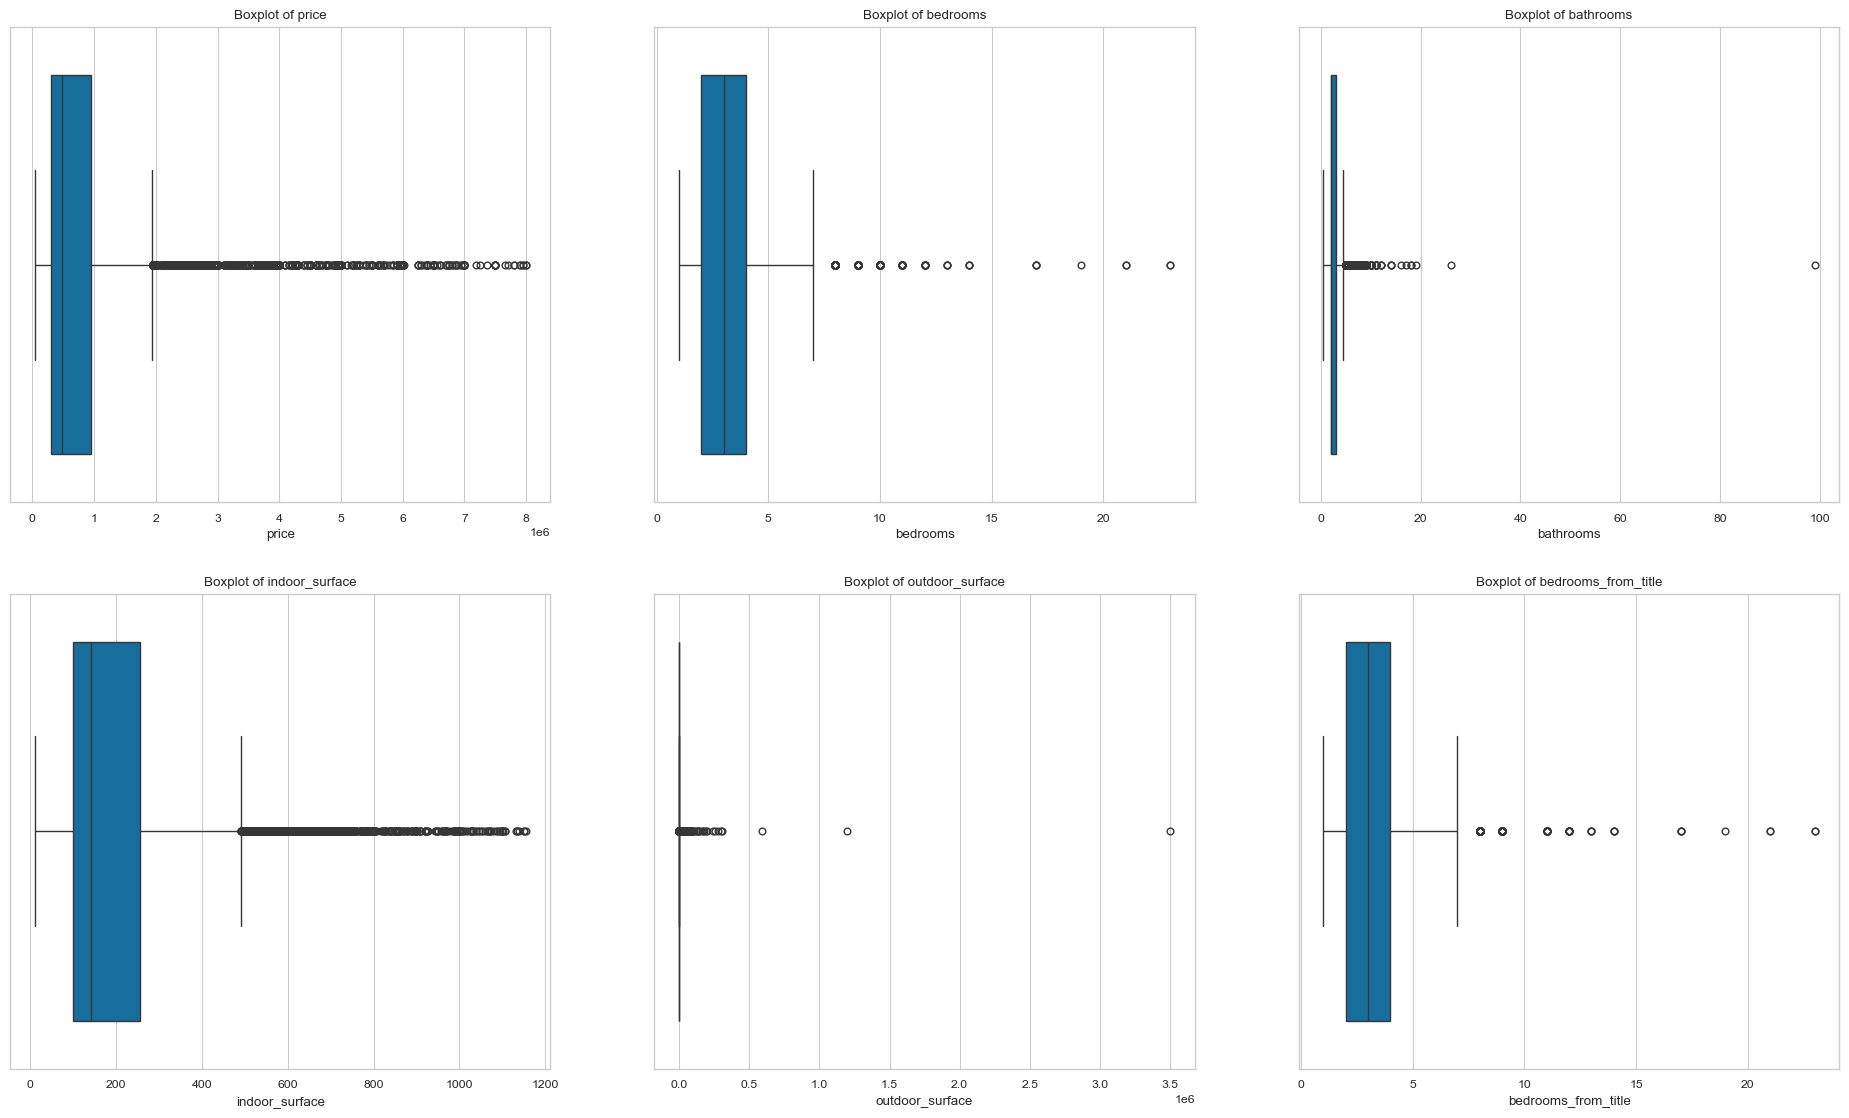

In [20]:
# --- 6. Outlier Detection (IQR) ---
print("\n--- 6. Outlier Detection (IQR Method) ---")
for col in continuousFeatures:
    valid_data = df[col].dropna()
    Q1 = valid_data.quantile(0.25)
    Q3 = valid_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = valid_data[(valid_data < lower_bound) | (valid_data > upper_bound)]
    
    if not outliers.empty:
        print(f"Outliers found in '{col}': {len(outliers)} ({len(outliers)/len(valid_data)*100:.1f}%)")
    else:
        print(f"No outliers found in '{col}'.")

print("\nGenerating boxplots for visual confirmation...")
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.tight_layout(pad=5.0) 
ax = axes.flatten()
for i in range(len(continuousFeatures)):
    col = continuousFeatures[i]
    sns.boxplot(data=df, x=col, ax=ax[i])
    ax[i].set_title(f"Boxplot of {col}")

for i in range(len(continuousFeatures), len(ax)):
    ax[i].set_visible(False)


# Inspect the top 10 most expensive properties to check for validity vs error
print("Top 10 High Price Outliers:")
display(df.sort_values('price', ascending=False)[['title', 'location', 'price', 'bedrooms', 'indoor_surface']].head(10))


plt.savefig('images/boxplots.pdf')
plt.show()

### Histograms

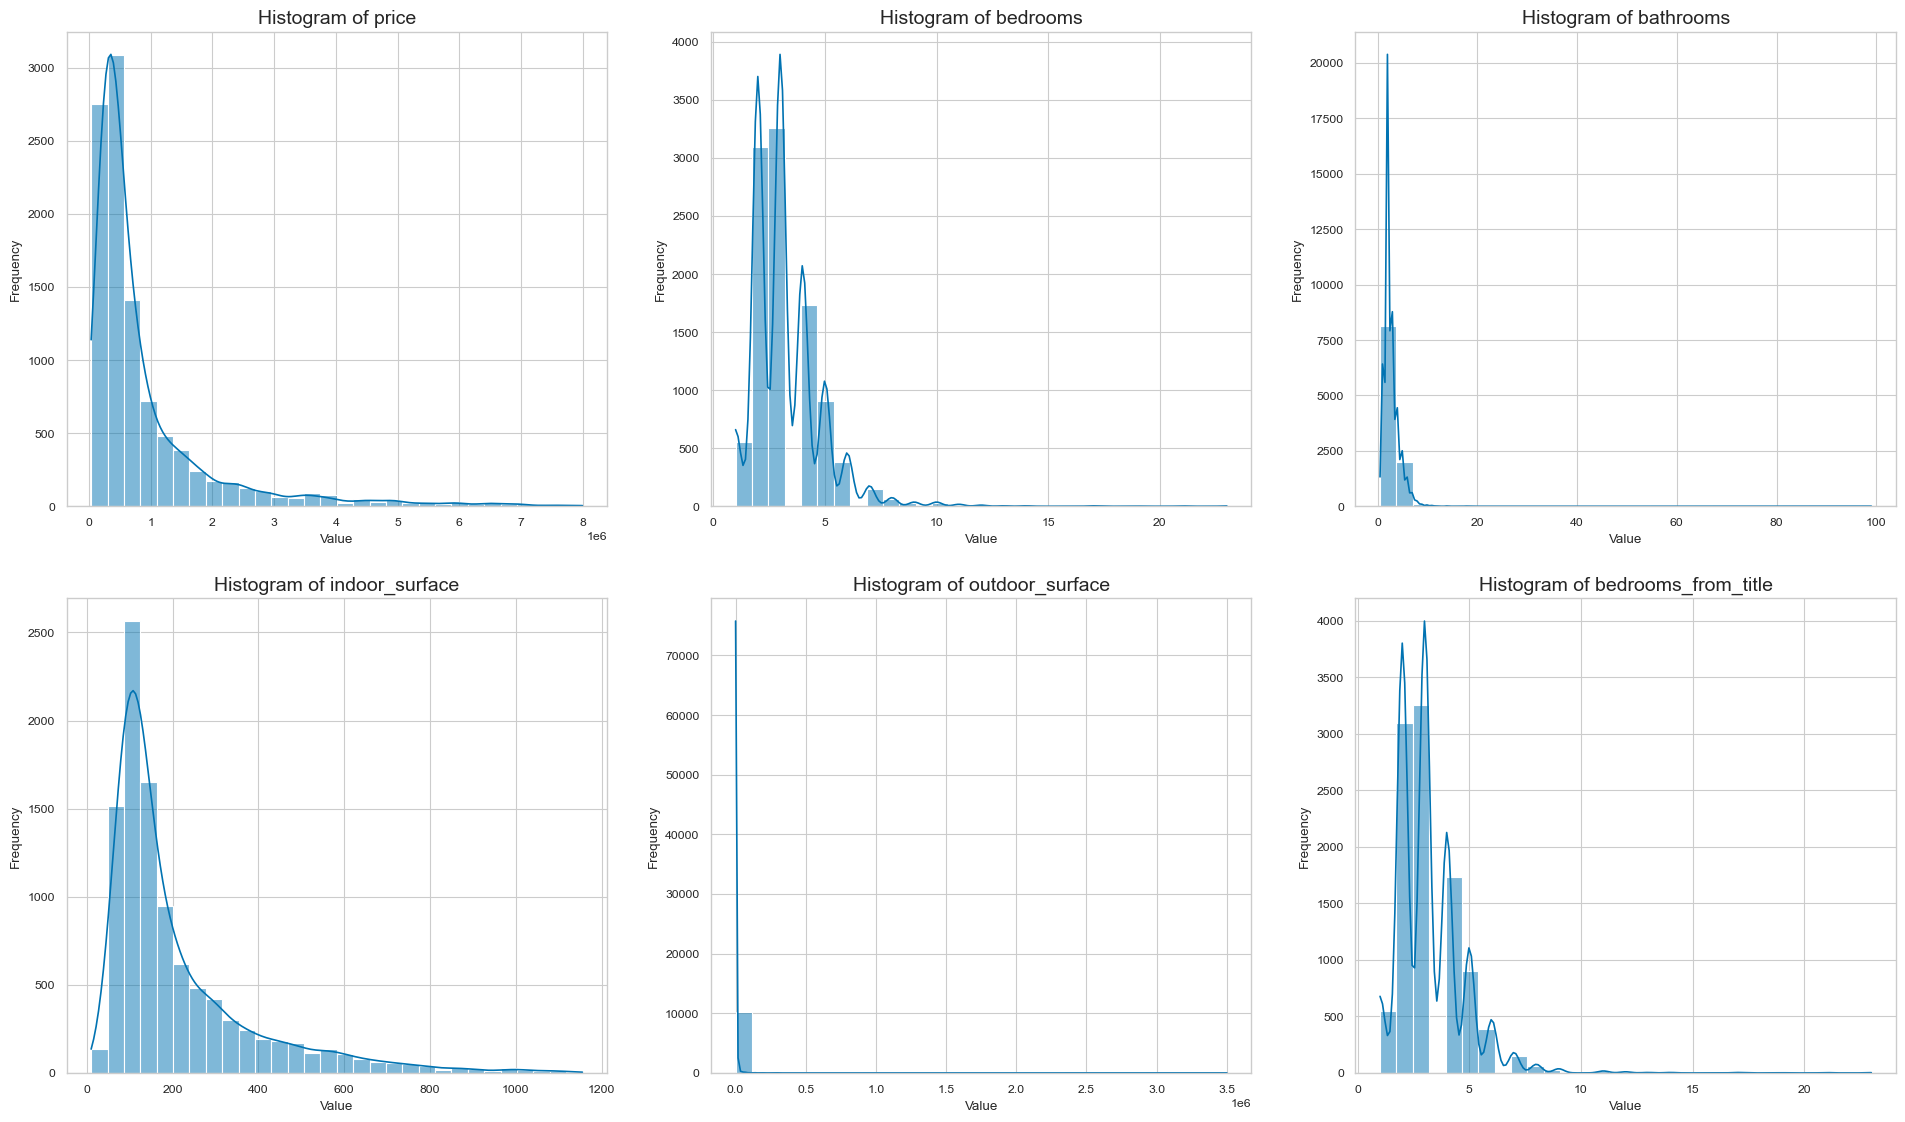

In [21]:
fig, ax = plt.subplots(2, 3, figsize=(20, 12))
fig.tight_layout(pad=5.0) 
ax = ax.flatten()

for i in range(len(continuousFeatures)):
    current_feature = continuousFeatures[i]
    sns.histplot(data=df, x=current_feature, bins=30, kde=True, ax=ax[i])
    ax[i].set_title(f'Histogram of {current_feature}', fontsize=14)
    ax[i].set_xlabel('Value')
    ax[i].set_ylabel('Frequency')

for i in range(len(continuousFeatures), len(ax)):
    ax[i].set_visible(False)

plt.savefig("images/histograms.pdf")
plt.show()

### Plot Relationships


Generating scatter plot for Indoor Surface vs. Price...


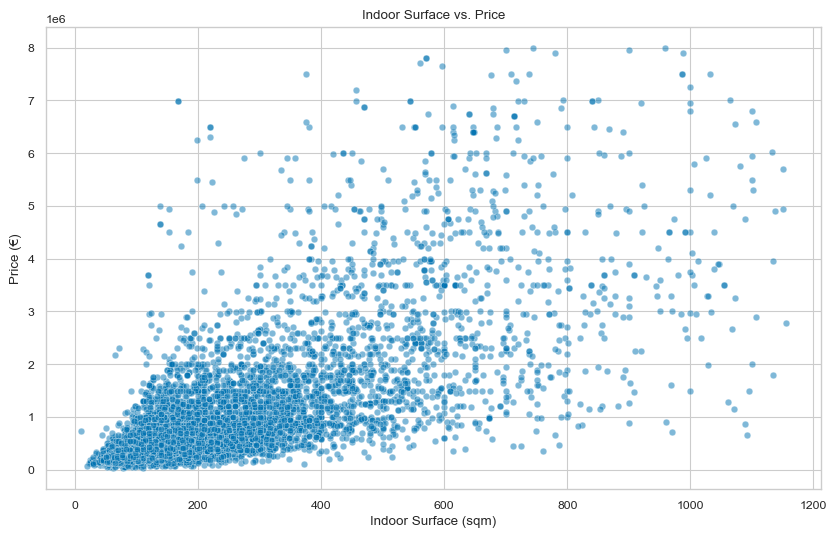


Generating box plot for Price vs Bedrooms...


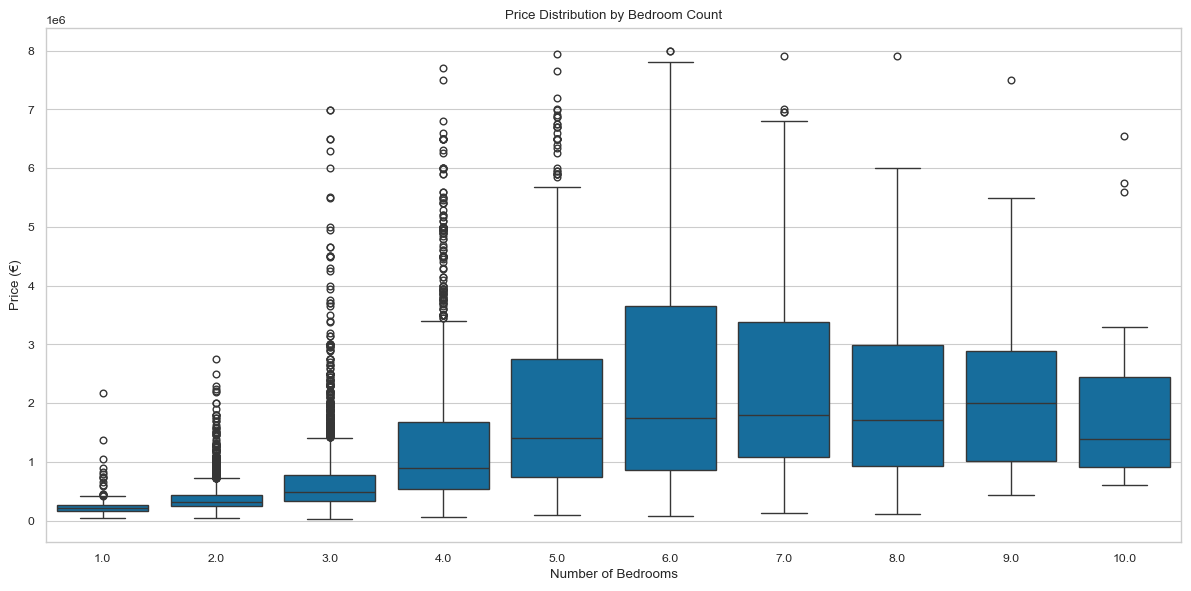


Generating Price vs Property Type...


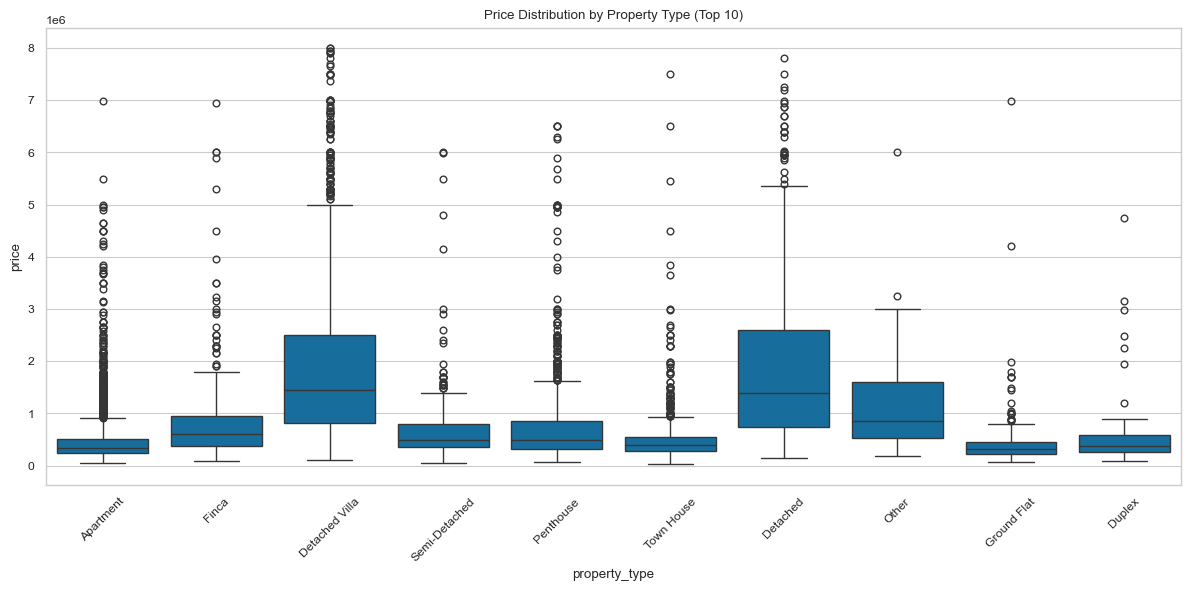


Generating Top Cities bar plot...


/tmp/ipykernel_394350/3711184661.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='city', data=df, order=top_cities, palette='viridis')


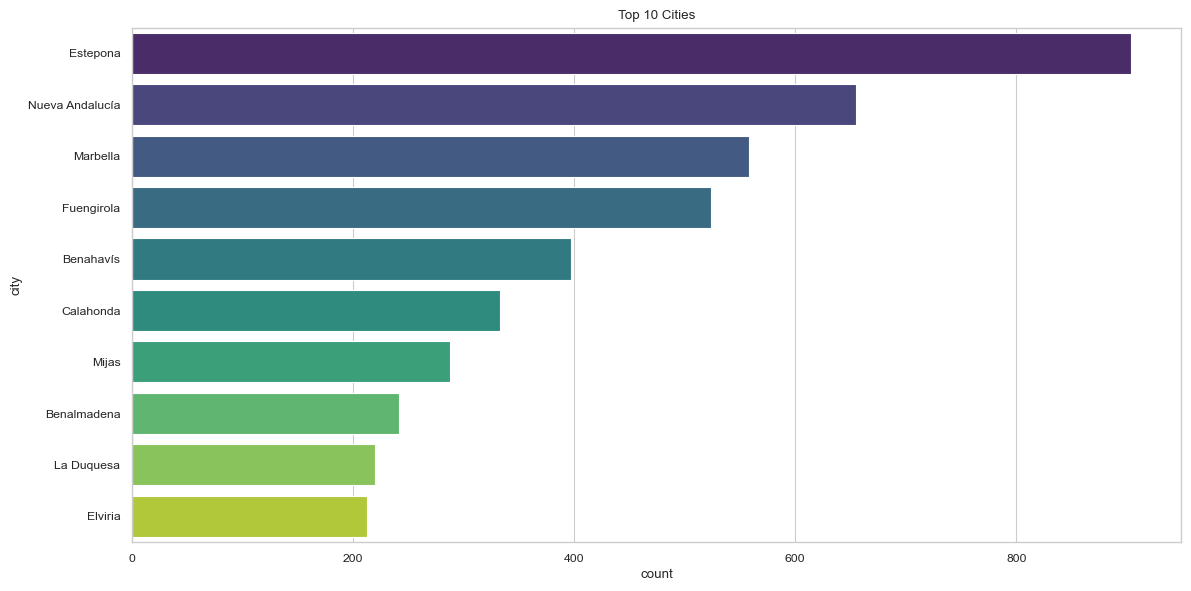


Generating Top Features bar plot...


/tmp/ipykernel_394350/3711184661.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_sums.values, y=feature_sums.index, palette='viridis')


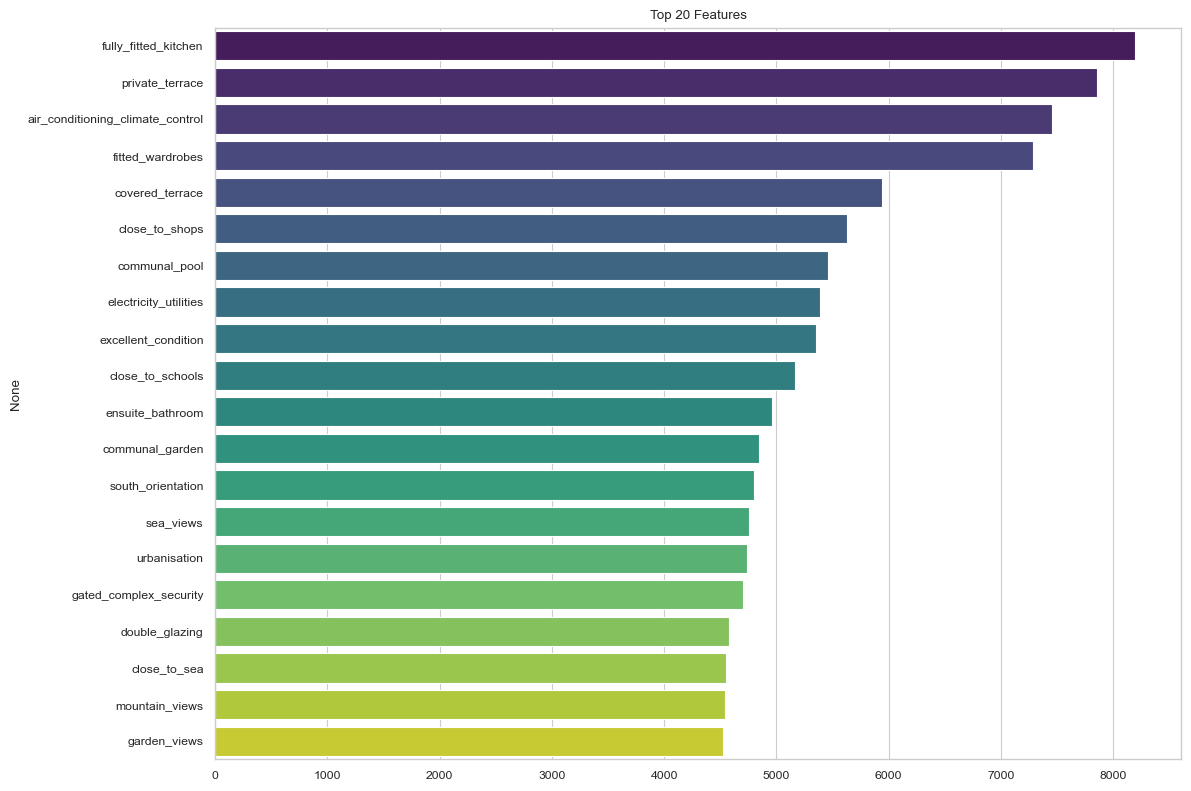


Generating bar plot for Top 10 Locations...


/tmp/ipykernel_394350/3711184661.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='location', data=df, order=top_locations, palette='viridis')


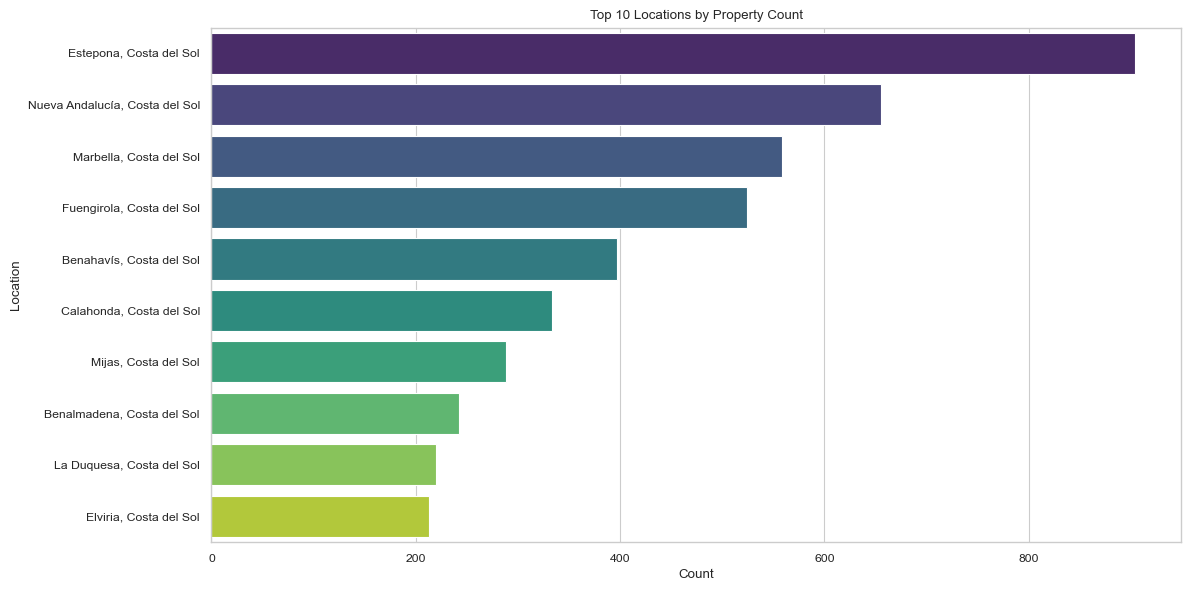


Generating bar plot for Top 20 Property Features...


/tmp/ipykernel_394350/3711184661.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_counts.values, y=feature_counts.index, palette='viridis')


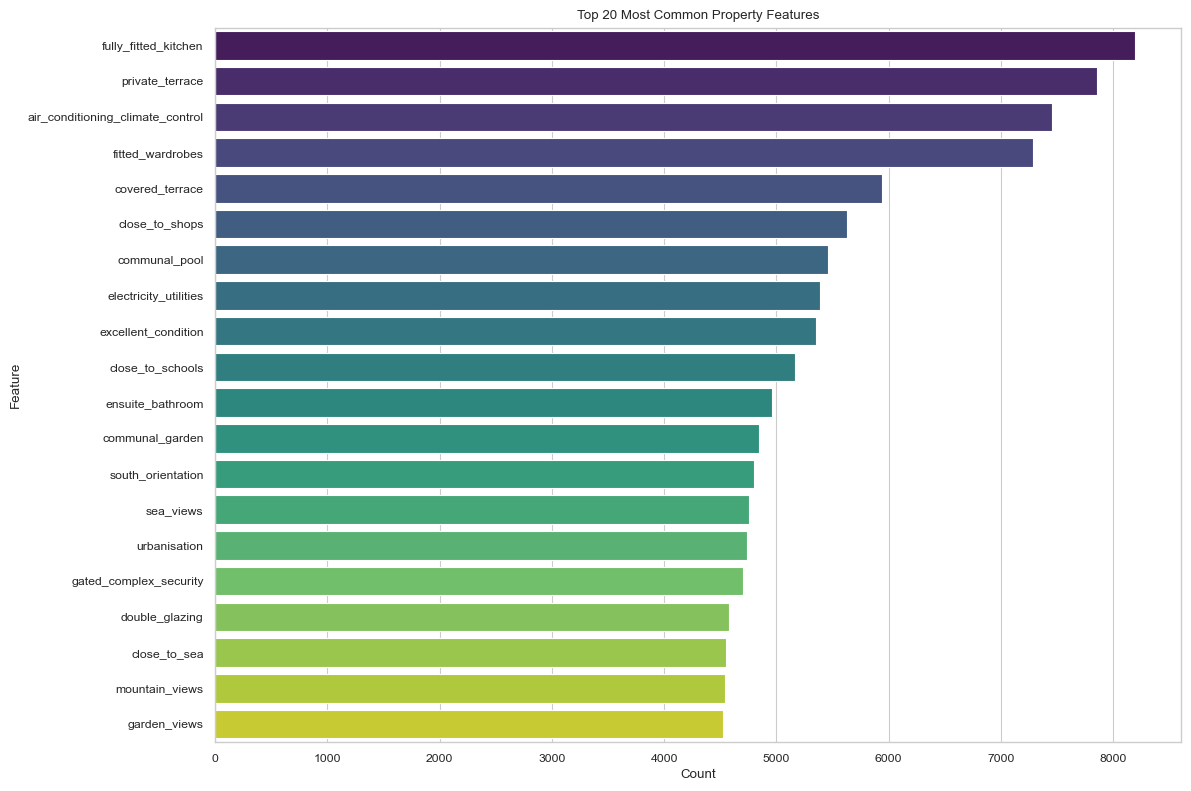

In [22]:
# Scatter Plot: Indoor Surface vs Price
print("\nGenerating scatter plot for Indoor Surface vs. Price...")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='indoor_surface', y='price', alpha=0.5)
plt.xlabel('Indoor Surface (sqm)')
plt.ylabel('Price (€)')
plt.title('Indoor Surface vs. Price')
plt.savefig('images/scatter_surface_price.pdf')
plt.show()

# Box Plot: Price vs Bedrooms
print("\nGenerating box plot for Price vs Bedrooms...")
plt.figure(figsize=(12, 6))
# Filter to reasonable bedroom counts (e.g., <= 10) to keep plot readable
subset_df = df[df['bedrooms'] <= 10]
sns.boxplot(x='bedrooms', y='price', data=subset_df)
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price (€)')
plt.title('Price Distribution by Bedroom Count')
plt.tight_layout()
plt.savefig('images/price_vs_bedrooms.pdf')
plt.show()


# 1. Price vs Property Type 
print("\nGenerating Price vs Property Type...")
plt.figure(figsize=(12, 6))
# Filter to top 10 property types for readability
top_types = df['property_type'].value_counts().nlargest(10).index
sns.boxplot(x='property_type', y='price', data=df[df['property_type'].isin(top_types)])
plt.xticks(rotation=45)
plt.title('Price Distribution by Property Type (Top 10)')
plt.tight_layout()
plt.savefig('images/price_vs_property_type.pdf')
plt.show()

# 2. Top Cities 
print("\nGenerating Top Cities bar plot...")
plt.figure(figsize=(12, 6))
top_cities = df['city'].value_counts().nlargest(10).index
sns.countplot(y='city', data=df, order=top_cities, palette='viridis')
plt.title('Top 10 Cities')
plt.tight_layout()
plt.savefig('images/top_cities.pdf')
plt.show()

# 3. Top Features
print("\nGenerating Top Features bar plot...")
# Calculate sum of binary features
feature_sums = df[binaryFeatures].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_sums.values, y=feature_sums.index, palette='viridis')
plt.title('Top 20 Features')
plt.tight_layout()
plt.savefig('images/top_features.pdf')
plt.show()

# Bar Plot: Top 10 Locations
print("\nGenerating bar plot for Top 10 Locations...")
top_locations = df['location'].value_counts().nlargest(10).index
plt.figure(figsize=(12, 6))
sns.countplot(y='location', data=df, order=top_locations, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Location')
plt.title('Top 10 Locations by Property Count')
plt.tight_layout()
plt.savefig('images/top_locations.pdf')
plt.show()

# Bar Plot: Top 20 Features (New!)
print("\nGenerating bar plot for Top 20 Property Features...")
# Sum the binary columns to get counts of each feature
feature_counts = df[binaryFeatures].sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_counts.values, y=feature_counts.index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Feature')
plt.title('Top 20 Most Common Property Features')
plt.tight_layout()
plt.savefig('images/top_features.pdf')
plt.show()

### Pair Plots

Generating pairplot for all continuous variables...


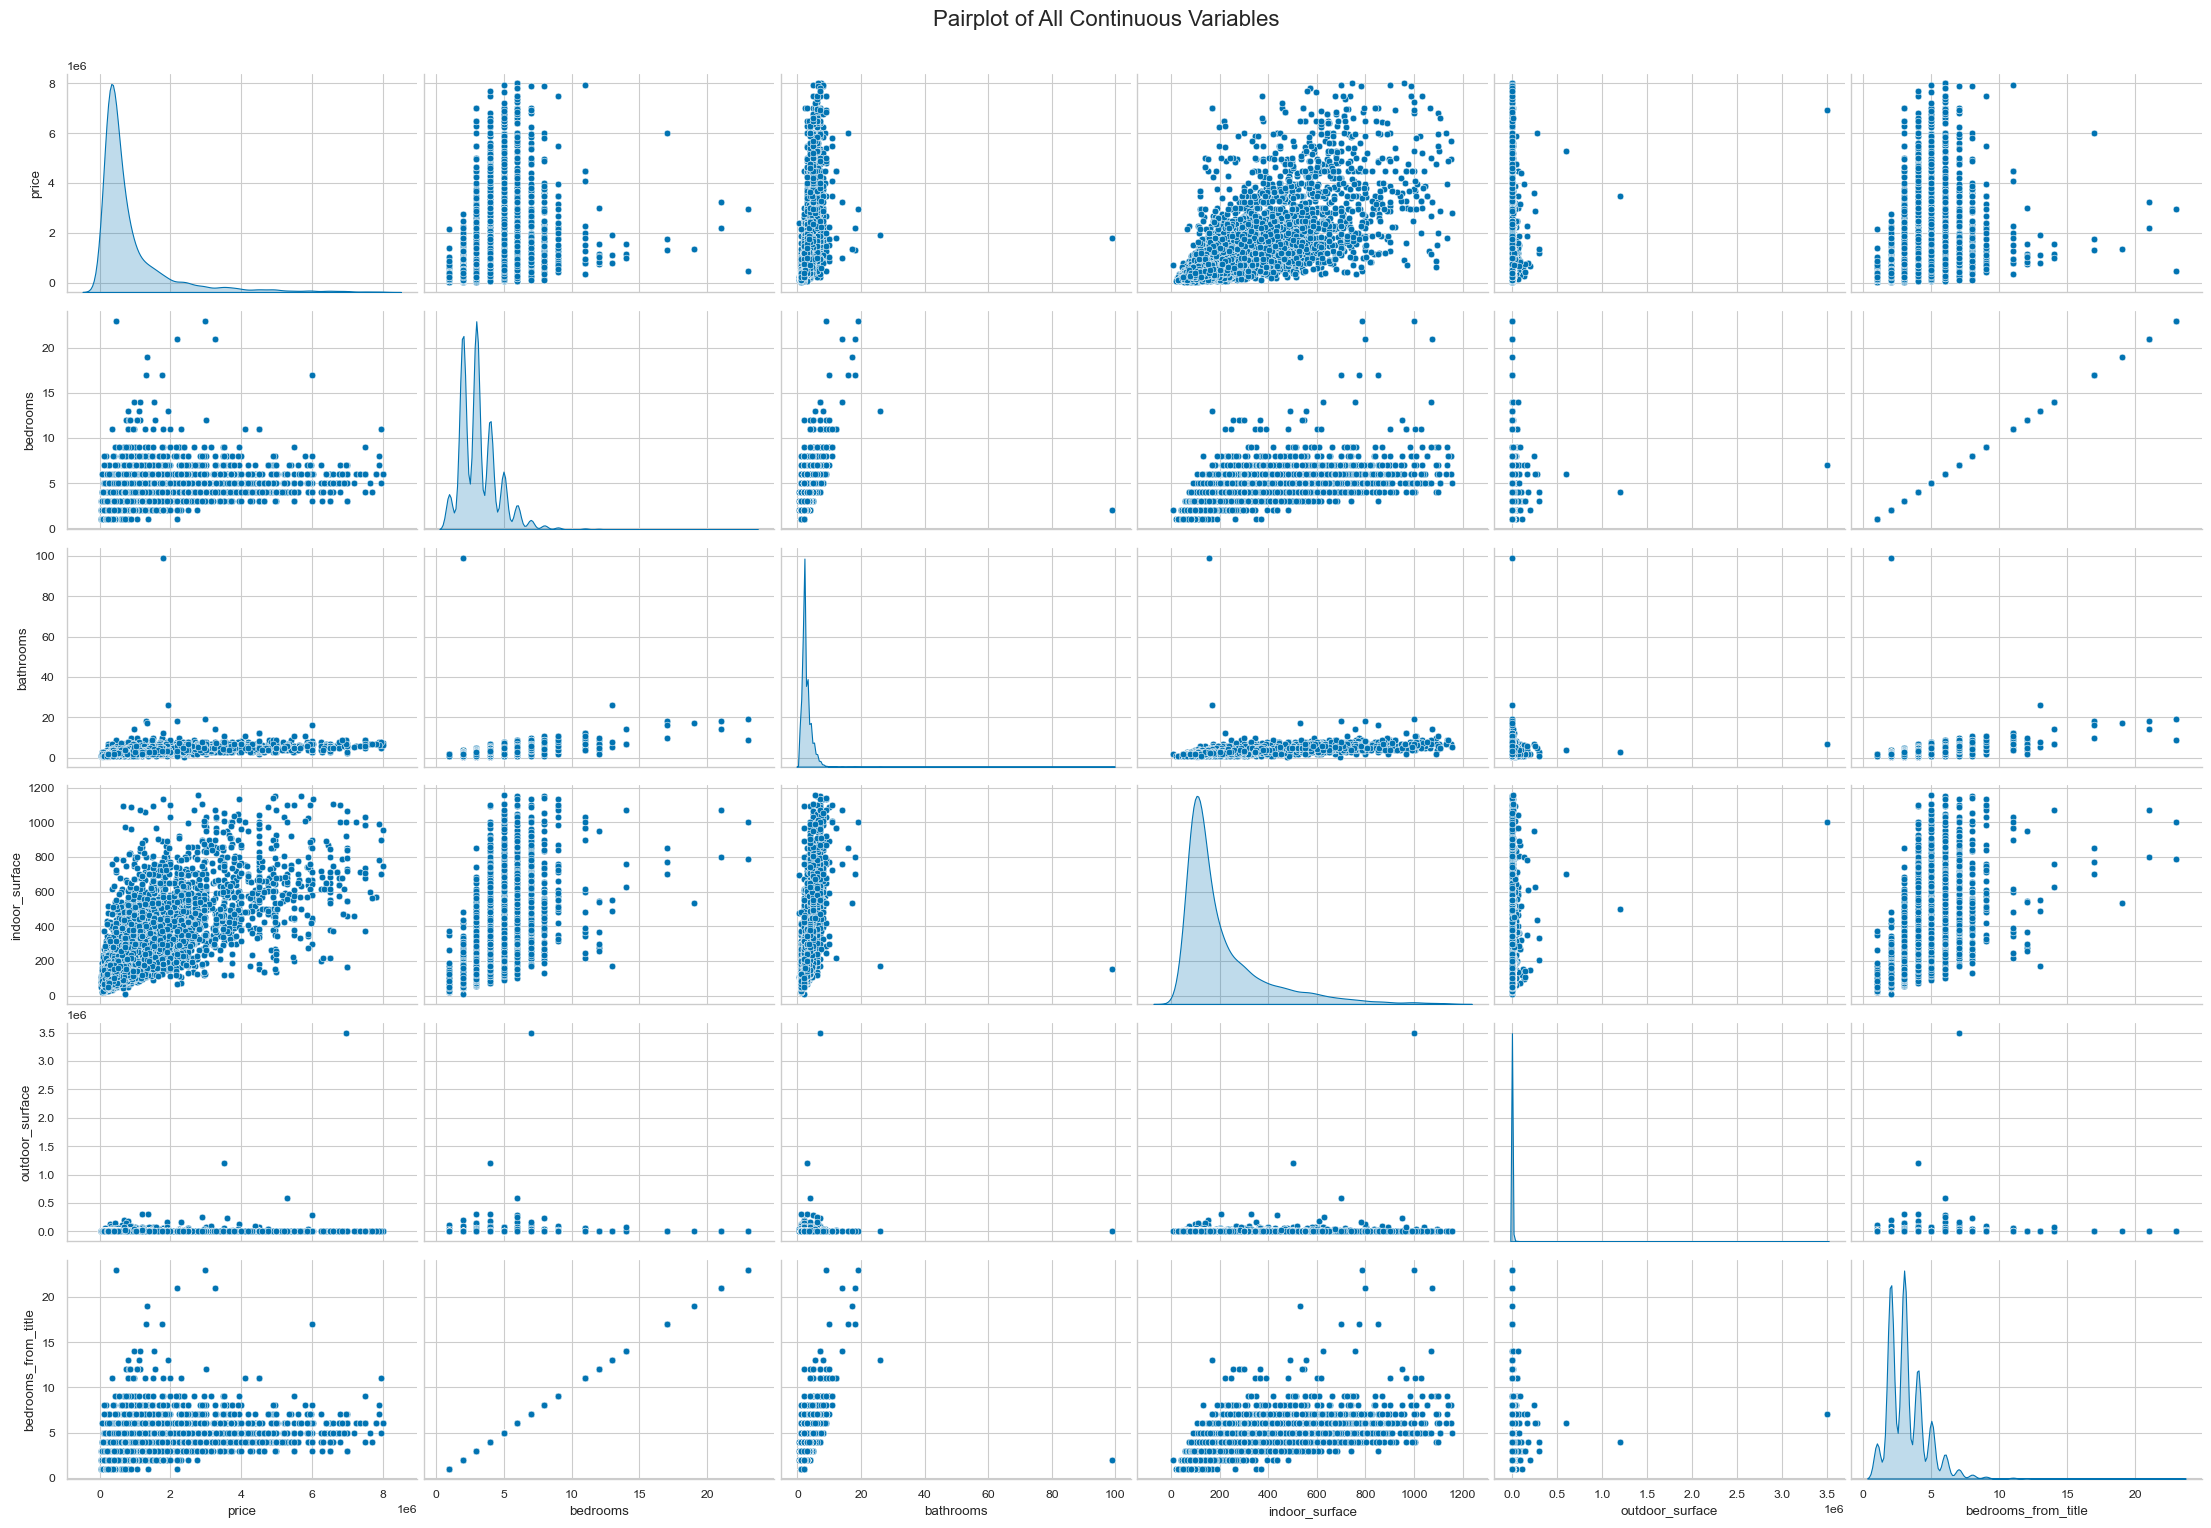


Generating Count Plots for Main Categories...


/tmp/ipykernel_394350/3323983233.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=top_cats, palette='viridis')


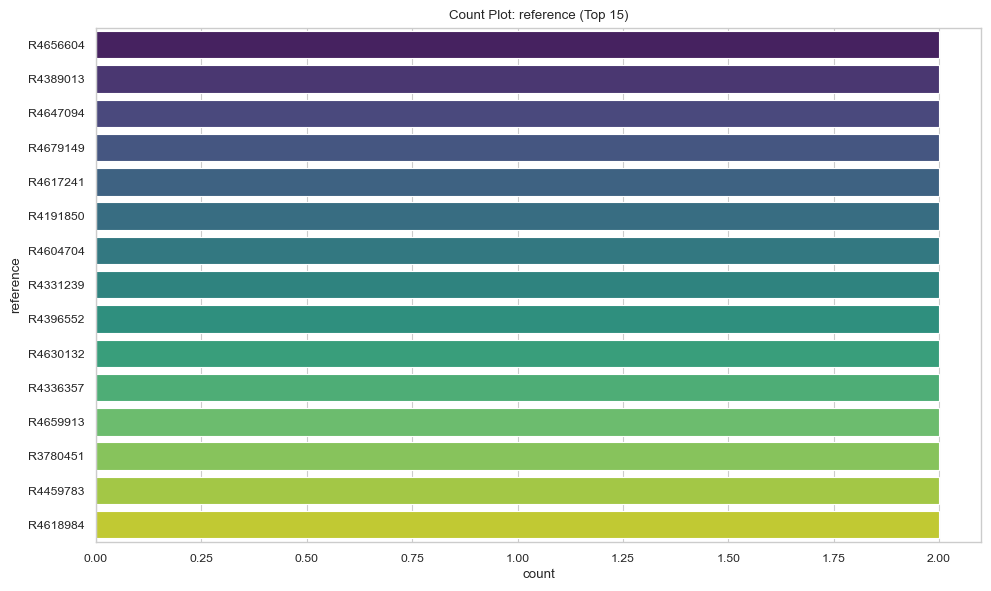

/tmp/ipykernel_394350/3323983233.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=top_cats, palette='viridis')


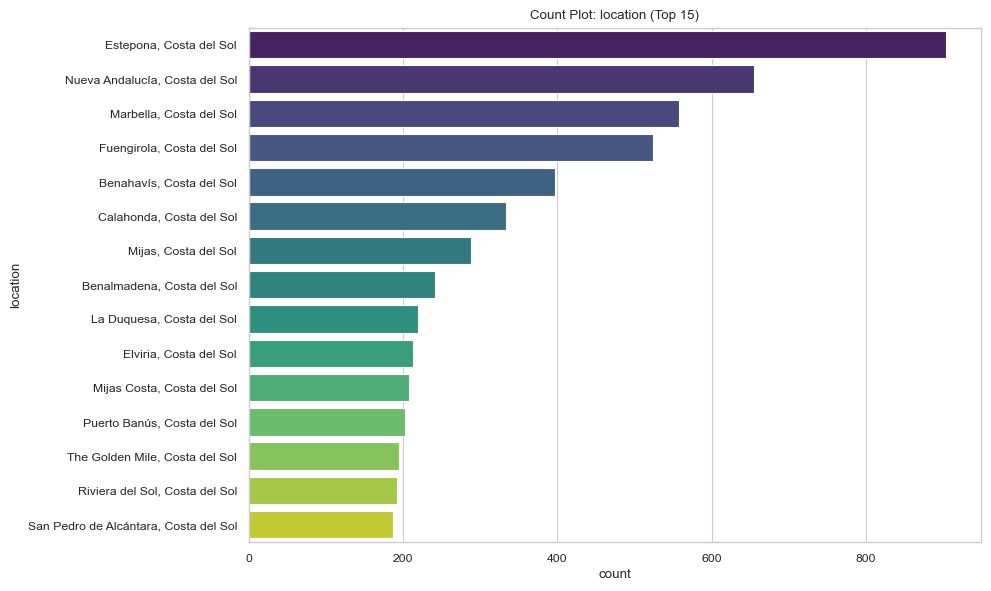

/tmp/ipykernel_394350/3323983233.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=top_cats, palette='viridis')


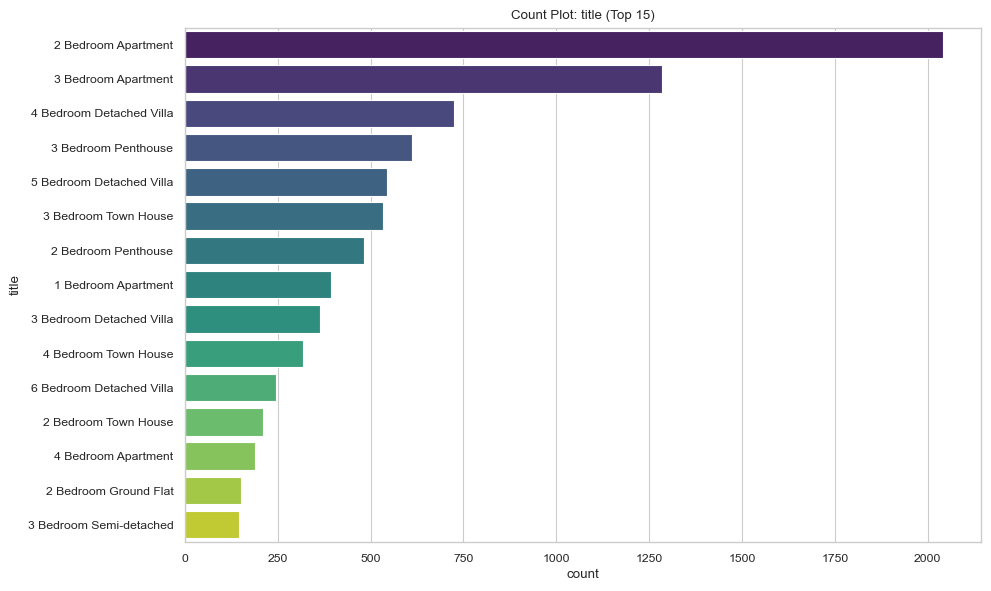

/tmp/ipykernel_394350/3323983233.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=top_cats, palette='viridis')
/tmp/ipykernel_394350/3323983233.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


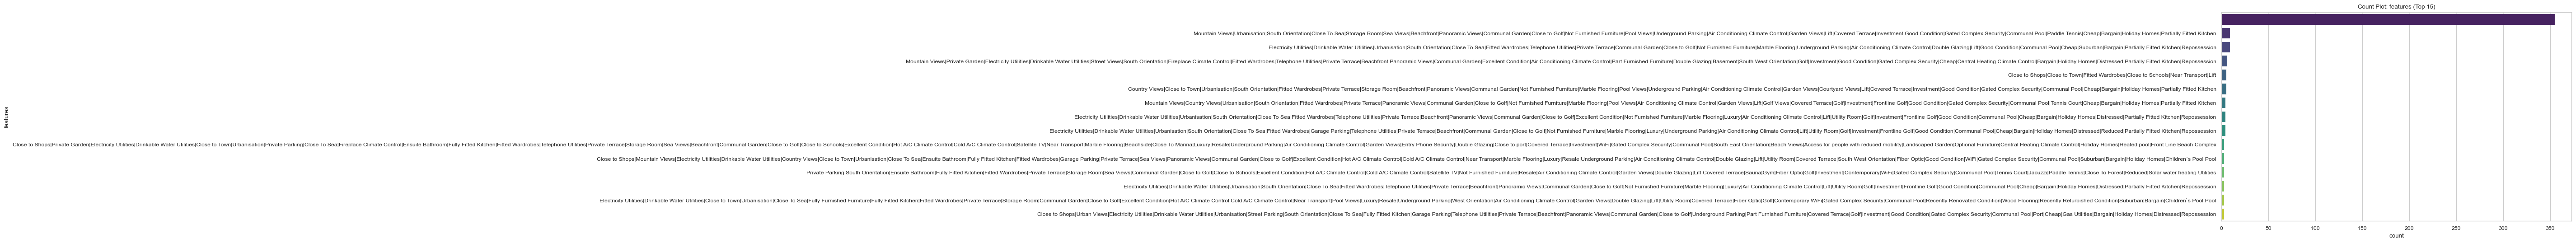

/tmp/ipykernel_394350/3323983233.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=top_cats, palette='viridis')


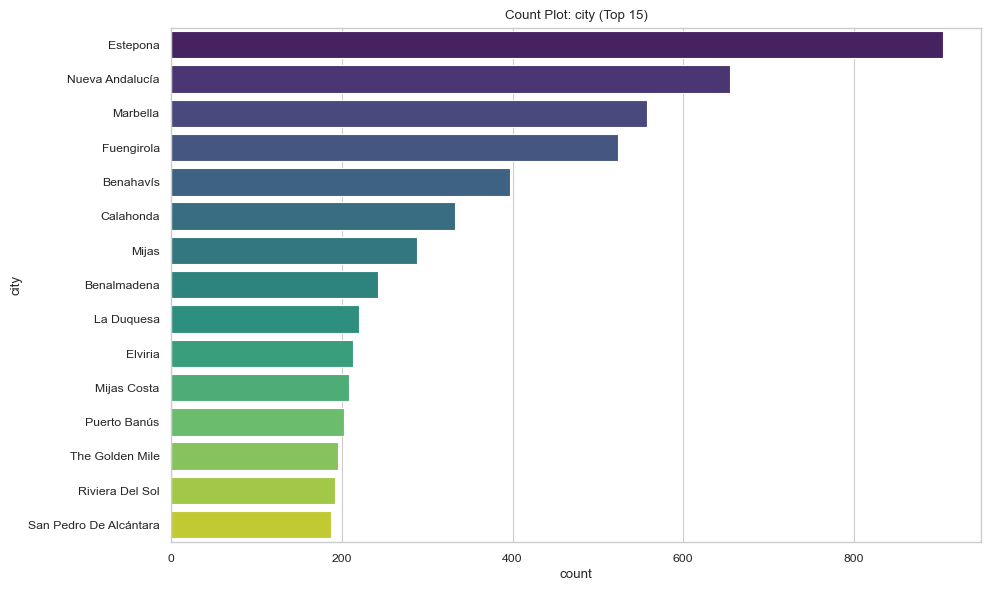

/tmp/ipykernel_394350/3323983233.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=top_cats, palette='viridis')


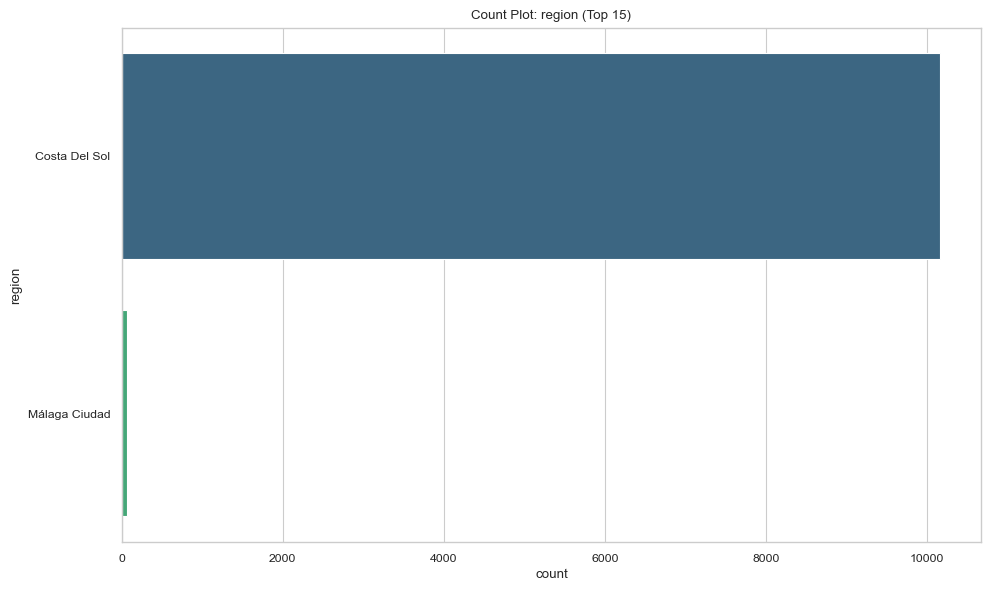

/tmp/ipykernel_394350/3323983233.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=top_cats, palette='viridis')


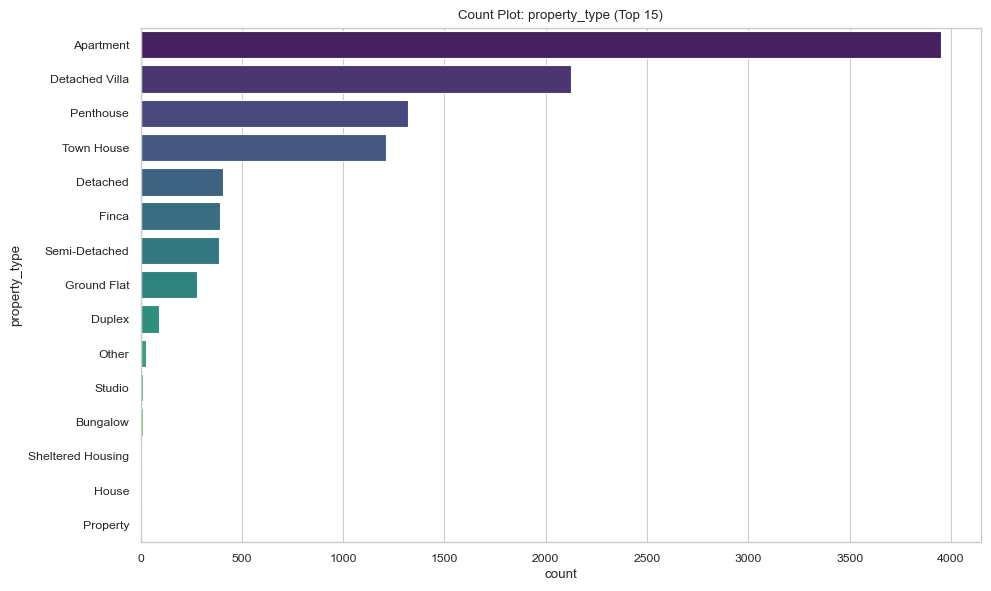


Generating Binary Feature Prevalence...


/tmp/ipykernel_394350/3323983233.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=binary_sums.values, y=binary_sums.index, palette='viridis')


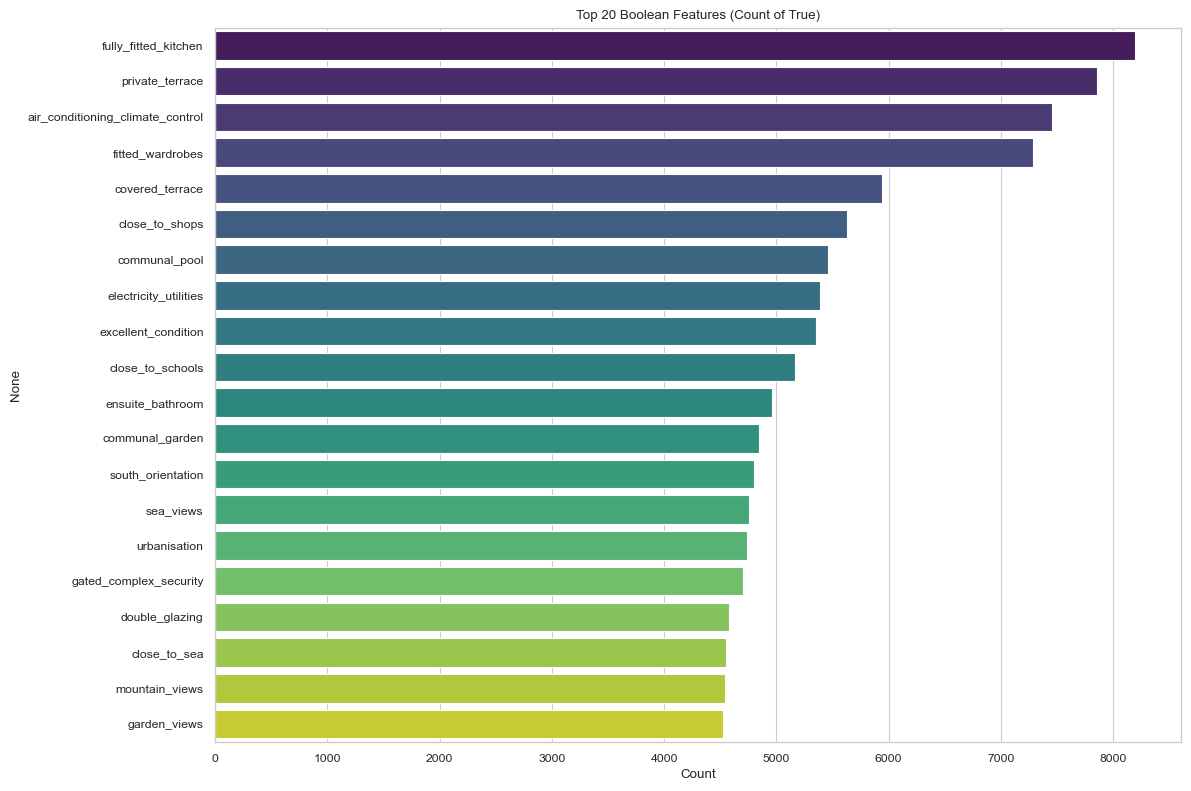

In [23]:
# --- Pairplot for ALL Continuous Variables ---
print("Generating pairplot for all continuous variables...")
sns.pairplot(df[continuousFeatures].dropna(), aspect=1.5, diag_kind='kde')
plt.suptitle('Pairplot of All Continuous Variables', y=1.02, fontsize=16)
plt.savefig('images/pairplot_all.png')
plt.show()
# --- B. Count Plots (Main Categorical) ---
print("\nGenerating Count Plots for Main Categories...")
for col in categoricalFeatures:
    plt.figure(figsize=(10, 6))
    # Top 15 categories only to prevent clutter
    top_cats = df[col].value_counts().nlargest(15).index
    sns.countplot(y=col, data=df, order=top_cats, palette='viridis')
    plt.title(f'Count Plot: {col} (Top 15)')
    plt.tight_layout()
    plt.savefig(f'images/countplot_{col}.pdf')
    plt.show()

# --- C. Feature Prevalence Plot (All Binaries) ---
print("\nGenerating Binary Feature Prevalence...")
# Summing boolean True values works like counting 1s
binary_sums = df[binaryFeatures].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x=binary_sums.values, y=binary_sums.index, palette='viridis')
plt.title('Top 20 Boolean Features (Count of True)')
plt.xlabel('Count')
plt.tight_layout()
plt.savefig('images/binary_prevalence.pdf')
plt.show()


### Correlation Matrix

Covariance Matrix:


,price,bedrooms,bathrooms,indoor_surface,outdoor_surface,bedrooms_from_title
price,1.205454e+12,867874.001994,1.112637e+06,1.431346e+08,3.694582e+09,849123.647407
bedrooms,8.678740e+05,2.405350,1.851690e+00,1.970841e+02,3.778376e+03,2.276475
bathrooms,1.112637e+06,1.851690,3.190030e+00,2.077045e+02,3.039396e+03,1.758108
indoor_surface,1.431346e+08,197.084098,2.077045e+02,3.112982e+04,6.229686e+05,189.131935
outdoor_surface,3.694582e+09,3778.375540,3.039396e+03,6.229686e+05,1.461626e+09,3616.334131
bedrooms_from_title,8.491236e+05,2.276475,1.758108e+00,1.891319e+02,3.616334e+03,2.276475




Calculating Pearson's Correlation...


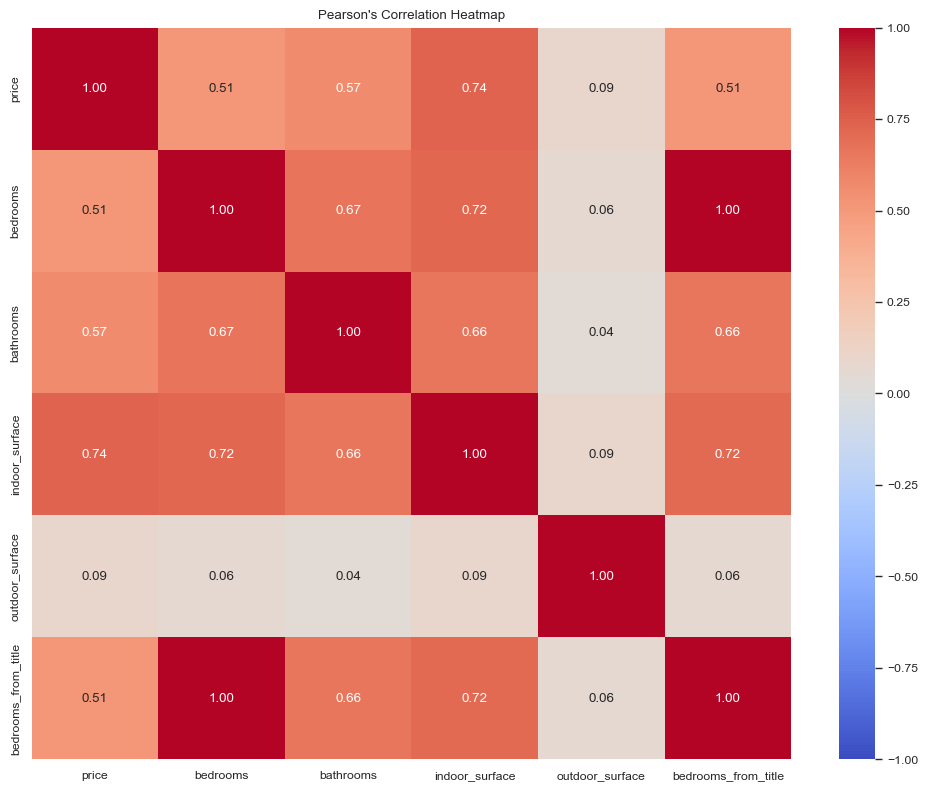

Calculating Spearman's Correlation...


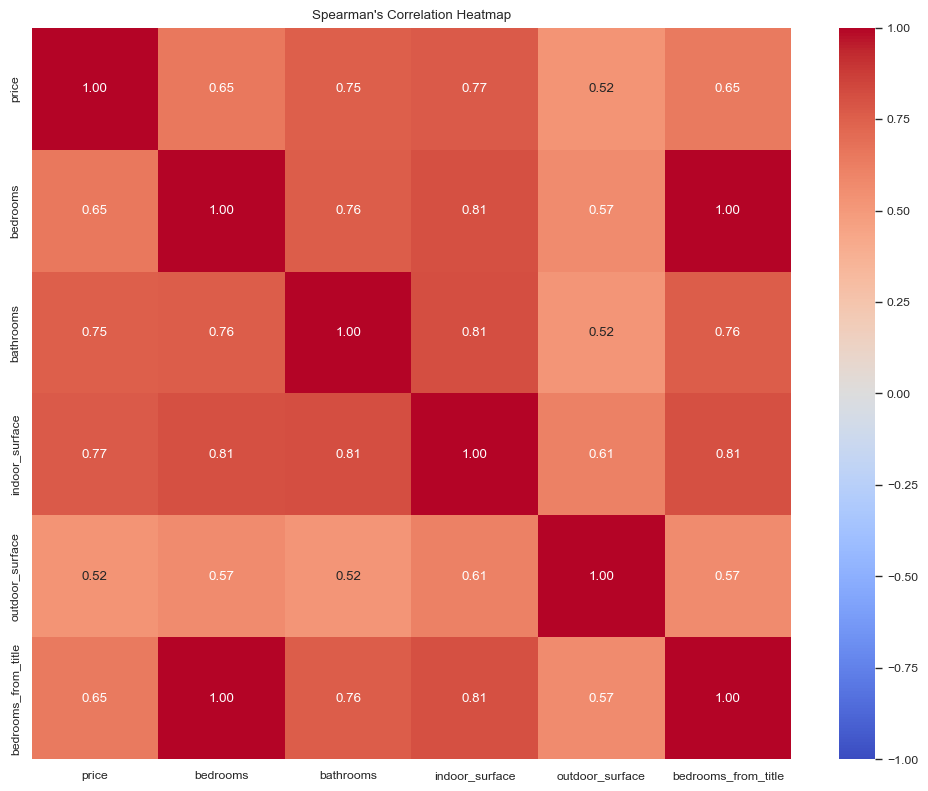

In [24]:
print("Covariance Matrix:")
covariance = df[continuousFeatures].cov()
display(covariance)
print("\n" + "="*80 + "\n") 

# --- Pearson's Correlation ---
print("Calculating Pearson's Correlation...")
plt.figure(figsize=(10, 8))
correlation = df[continuousFeatures].corr(method='pearson')
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Pearson's Correlation Heatmap")
plt.tight_layout()
plt.savefig('images/pearson_correlation.pdf')
plt.show()

# --- Spearman's Correlation ---
print("Calculating Spearman's Correlation...")
plt.figure(figsize=(10, 8))
correlationSp = df[continuousFeatures].corr(method='spearman')
sns.heatmap(correlationSp, vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Spearman's Correlation Heatmap")
plt.tight_layout()
plt.savefig('images/spearman_correlation.pdf')
plt.show()

### More detailed


Generating Pearson Correlation Matrix...


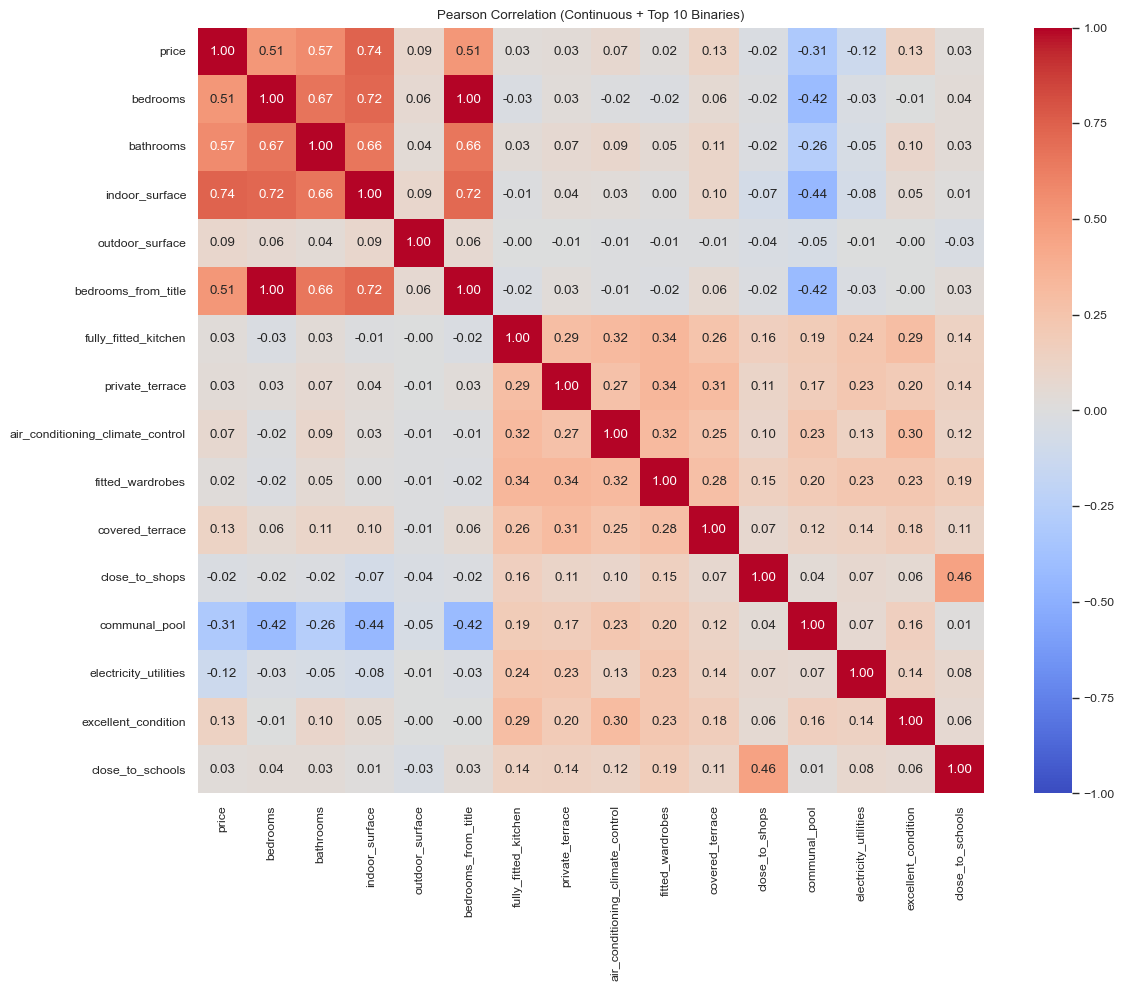


Generating Spearman Correlation Matrix...


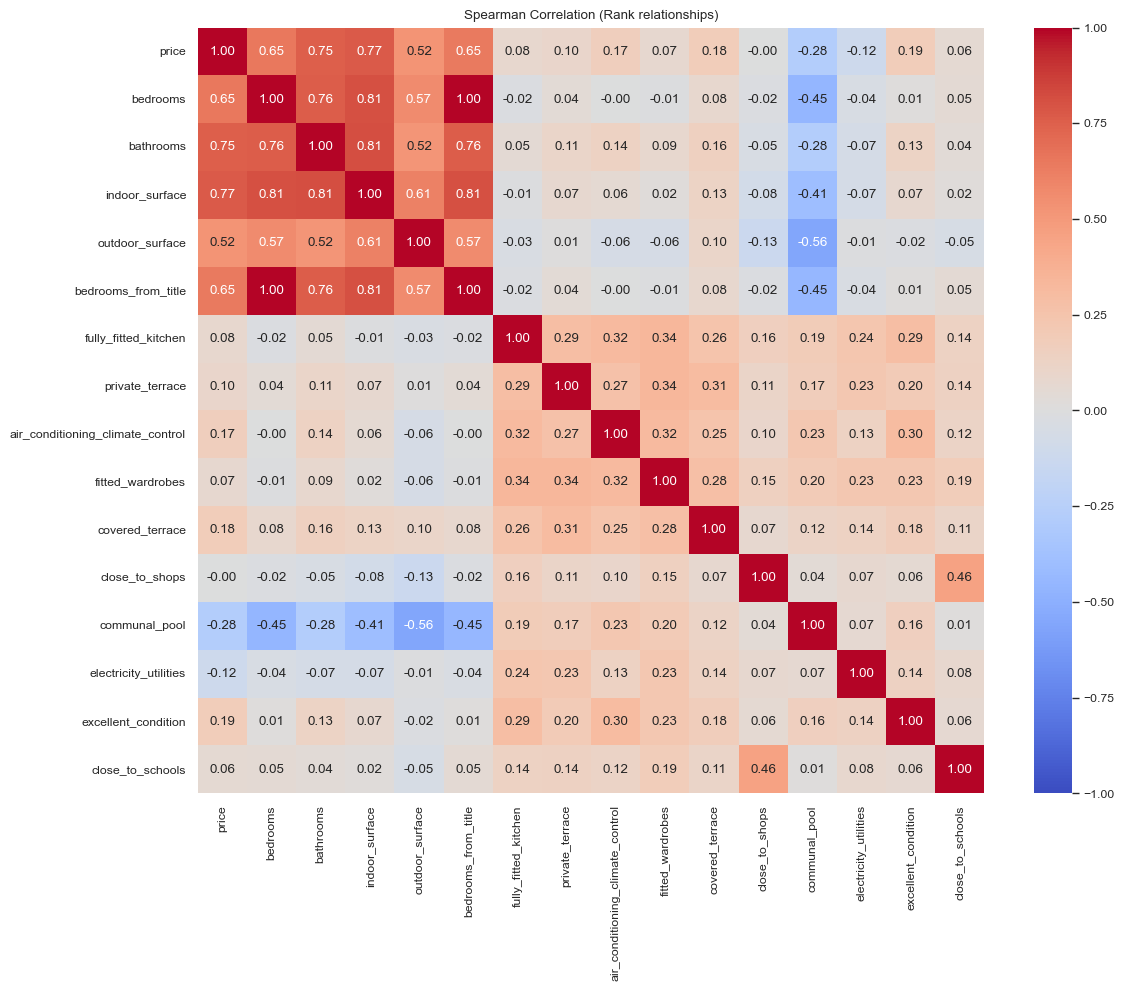

In [25]:
# Prepare data for correlation:
# We must convert booleans to integers (0/1) specifically for the correlation matrix calculation,
    # otherwise .corr() might ignore them depending on pandas version.
corr_df = df[continuousFeatures].copy()
# Add top 10 binary features to correlation matrix for relevance
top_binaries = df[binaryFeatures].sum().sort_values(ascending=False).head(10).index
for col in top_binaries:
    corr_df[col] = df[col].astype(int)

# 1. Pearson
print("\nGenerating Pearson Correlation Matrix...")
plt.figure(figsize=(12, 10))
pearson_corr = corr_df.corr(method='pearson')
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Pearson Correlation (Continuous + Top 10 Binaries)")
plt.tight_layout()
plt.savefig('images/correlation_pearson.pdf')
plt.show()

# 2. Spearman
print("\nGenerating Spearman Correlation Matrix...")
plt.figure(figsize=(12, 10))
spearman_corr = corr_df.corr(method='spearman')
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Spearman Correlation (Rank relationships)")
plt.tight_layout()
plt.savefig('images/correlation_spearman.pdf')
plt.show()

In [26]:
# --- G. High Correlation Analysis (Target: Price) ---
print("\n" + "="*30 + " HIGH CORRELATION ANALYSIS " + "="*30)

# 1. Prepare Data: Combine Continuous and Binary (converted to int)
# Note: We use .corrwith to check correlation specifically against 'price' efficiently
analysis_df = df[continuousFeatures].copy()
# Add binary features as integers (0/1) so they can be correlated
analysis_df = pd.concat([analysis_df, df[binaryFeatures].astype(int)], axis=1)

# 2. Calculate Correlation with Price
price_correlations = analysis_df.corrwith(analysis_df['price'])

n = 0.18

# 3. Filter for Absolute Correlation > 0.5
# We drop 'price' itself as it will always be 1.0
high_corr_features = price_correlations[abs(price_correlations) > n].drop('price', errors='ignore')
high_corr_features = high_corr_features.sort_values(ascending=False)

print(f"Features with Absolute Correlation > {n} with Price:")
if not high_corr_features.empty:
    display(high_corr_features.to_frame(name='Correlation Coefficient'))
else:
    print(f"No features found with correlation > {n}.")


============================== HIGH CORRELATION ANALYSIS ==============================
Features with Absolute Correlation > 0.18 with Price:


,Correlation Coefficient
indoor_surface,0.738892
bathrooms,0.567389
bedrooms_from_title,0.514020
bedrooms,0.509674
private_pool,0.509559
private_garden,0.382367
u/f_heating_climate_control,0.355691
luxury,0.345941
alarm_system_security,0.291381
games_room,0.281618


### Final Data Retention Summary

In [27]:
print("\n" + "="*40 + "\n   FINAL DATA FLOW SUMMARY\n" + "="*40)

final_count = len(df)

summary_stats = [
    {
        'Stage': '1. Original Raw Data', 
        'Count': initial_count, 
        'Retention %': 100.0,
        'Rows Dropped': 0
    },
    {
        'Stage': '2. After Category Masking (Residential Filter)', 
        'Count': filtered_count, 
        'Retention %': (filtered_count / initial_count) * 100,
        'Rows Dropped': initial_count - filtered_count
    },
    {
        'Stage': '3. After Outlier Removal (Final Dataset)', 
        'Count': final_count, 
        'Retention %': (final_count / initial_count) * 100,
        'Rows Dropped': filtered_count - final_count
    }
]

summary_df = pd.DataFrame(summary_stats)

# Display formatted table
display(summary_df.round(2))

print(f"\nConclusion: Analysis is based on {final_count} cleaned residential properties.")
print(f"Total Data Reduction: {(1 - final_count/initial_count)*100:.1f}% of original rows were removed.")


   FINAL DATA FLOW SUMMARY


,Stage,Count,Retention %,Rows Dropped
0,1. Original Raw Data,12086,100.00,0
1,2. After Category Masking (Residential Filter),10605,87.75,1481
2,3. After Outlier Removal (Final Dataset),10229,84.64,376



Conclusion: Analysis is based on 10229 cleaned residential properties.
Total Data Reduction: 15.4% of original rows were removed.


### 7. Save Analyzed Data

In [28]:
# ==========================================
# 
# ==========================================
print("\n" + "="*40 + "\n   SAVING DATA\n" + "="*40)

output_filename = "../data/properties_cleaned.csv"
df.to_csv(output_filename, index=False)

print(f"Success! The cleaned dataset has been saved to '{output_filename}'.")
print(f"File contains {len(df)} rows and {len(df.columns)} columns.")


   SAVING DATA
Success! The cleaned dataset has been saved to '../data/properties_cleaned.csv'.
File contains 10229 rows and 160 columns.
